## Input parameters

In [1]:
batch_size = 32
learning_rate = 0.0005
noise_dim = 32 # dimension of random noise as generator's input
layers_dim = 128 # dimension at layers inside NN
epochs = 100000+1
model_name = 'model'
noise_dim = 32

## Install libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn.datasets as ds
from sklearn.preprocessing import StandardScaler

import tensorflow
from tensorflow.keras.layers import Input, Dense, Dropout, ReLU, LeakyReLU
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import keras

import os
import sys

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import wasserstein_distance
from table_evaluator import load_data, TableEvaluator

## Prepare data

In [3]:
# Load data

dfdiabetes_x = pd.DataFrame(ds.load_diabetes().data)
dfdiabetes_x.columns = ds.load_diabetes().feature_names
dfdiabetes_y = pd.DataFrame(ds.load_diabetes().target)
dfdiabetes_y.columns = ['Outcome']
df = pd.concat([dfdiabetes_x,dfdiabetes_y], axis=1)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Outcome
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [4]:
# Scale data

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Outcome
0,0.800500,1.065488,1.297088,0.459840,-0.929746,-0.732065,-0.912451,-0.054499,0.418551,-0.370989,-0.014719
1,-0.039567,-0.938537,-1.082180,-0.553511,-0.177624,-0.402886,1.564414,-0.830301,-1.436551,-1.938479,-1.001659
2,1.793307,1.065488,0.934533,-0.119218,-0.958674,-0.718897,-0.680245,-0.054499,0.060207,-0.545154,-0.144580
3,-1.872441,-0.938537,-0.243771,-0.770658,0.256292,0.525397,-0.757647,0.721302,0.477072,-0.196823,0.699513
4,0.113172,-0.938537,-0.764944,0.459840,0.082726,0.327890,0.171178,-0.054499,-0.672582,-0.980568,-0.222496


## GAN

In [5]:
class GAN():
    
    def __init__(self, batch_size, learning_rate, noise_dim, data_dim, layers_dim):
        # Initialize input values
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.noise_dim = noise_dim
        self.data_dim = data_dim
        self.layers_dim = layers_dim
        
        def create_generator(batch_size, input_shape, layers_dim, data_dim):
            input = Input(shape=input_shape, batch_size=batch_size)
            x = Dense(layers_dim)(input)
            x = ReLU()(x)
            x = Dense(layers_dim * 2)(x)
            x = ReLU()(x)
            x = Dense(layers_dim * 4)(x)
            x = ReLU()(x)
            x = Dense(data_dim)(x)
            return Model(inputs=input, outputs=x)
    
        def create_discriminator(batch_size, input_shape, layers_dim):
            input = Input(shape=input_shape, batch_size=batch_size)
            x = Dense(layers_dim * 4)(input)
            x = LeakyReLU()(x)
            x = Dropout(0.1)(x)
            x = Dense(layers_dim * 2)(x)
            x = LeakyReLU()(x)
            x = Dropout(0.1)(x)
            x = Dense(layers_dim)(x)
            x = LeakyReLU()(x)
            x = Dense(1, activation='sigmoid')(x)
            return Model(inputs=input, outputs=x)
        
        self.generator = create_generator(self.batch_size, (self.noise_dim,), self.layers_dim, self.data_dim)
        self.discriminator = create_discriminator(self.batch_size, (self.data_dim,), self.layers_dim)
        
        # Adam optimizer
        opt = Adam(self.learning_rate)
        # Discriminator is a binary classification real/fake -> loss is binary crossentropy and metric accuracy
        self.discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])        
        
        # STRUCTURE
        def create_gan(self):
            # For the combined model, only train the generator
            self.discriminator.trainable = False
            
            gen_input = Input(shape=(self.noise_dim,)) # The generator takes noise as input
            gen_output = self.generator(gen_input)
            
            disc_output = self.discriminator(gen_output) # The discriminator takes generated images as input 
            
            # GAN model: generator + discriminator
            gan = Model(gen_input, disc_output)
            gan.compile(loss='binary_crossentropy', optimizer=opt)
            
            return gan
        
        self.gan = create_gan(self)

    def train(self, data, epochs, model_name):        
        ones = np.ones((self.batch_size, 1))
        zeros = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # First input: to the generator 
            noise = tensorflow.random.normal((self.batch_size, self.noise_dim)) #batch_size x noise_dim 
            # Generator - Noise inputs the generator 
            gen_data = self.generator.predict(noise)
            # Second input: to the discriminator from real data
            real_data = data.sample(n = batch_size).to_numpy()
             
            # Train the discriminator on both paths: from real data and from generated data
            # When data is real, it outputs 1; when data is generated, it outputs 0
            dloss_real = self.discriminator.train_on_batch(real_data, ones)
            dloss_gen = self.discriminator.train_on_batch(gen_data, zeros)
            d_loss = np.add(dloss_real, dloss_gen)/2
    
            # Train the generator to fool the discriminator
            # When data comes from noise and is generated, it outputs 1
            noise = tensorflow.random.normal((self.batch_size, self.noise_dim))
            g_loss = self.gan.train_on_batch(noise, ones)
    
            # Save losses from generator and discriminator
            genlosses.append(g_loss)
            disclosses.append(d_loss[0])
            
            # Plot the progress every 10 epochs
            if epoch % 10 == 0:
                print("Epoch %d with discriminator loss %f and generator loss %f (x100)" % (epoch, d_loss[0]*100, g_loss*100))
                        
            # Save model every 100 epochs
            if epoch % 100 == 0:
                self.generator.save_weights(model_name + '/gen_weights_' + str(epoch) + '.h5')
                self.discriminator.save_weights(model_name + '/disc_weights_' + str(epoch) + '.h5')
            noise = tensorflow.random.normal((123, self.noise_dim))
            gen_data = self.generator(noise)
    
    # Save generator weights
    def save(self, path):
        self.generator.save_weights(path)

## GAN training

In [6]:
genlosses = []
disclosses = []
data_dim = df.shape[1]

if not os.path.exists(model_name):
    os.mkdir(model_name)

model = GAN(batch_size, learning_rate, noise_dim, data_dim, layers_dim)
model.train(df, epochs, model_name)
model.save(model_name + '/gan/saved/generator')

Epoch 0 with discriminator loss 71.353781 and generator loss 68.477136 (x100)
Epoch 10 with discriminator loss 50.770532 and generator loss 71.657276 (x100)
Epoch 20 with discriminator loss 22.423035 and generator loss 229.188728 (x100)
Epoch 30 with discriminator loss 34.271987 and generator loss 274.474764 (x100)
Epoch 40 with discriminator loss 16.510647 and generator loss 301.819372 (x100)
Epoch 50 with discriminator loss 20.101893 and generator loss 298.902059 (x100)
Epoch 60 with discriminator loss 10.952092 and generator loss 376.687074 (x100)
Epoch 70 with discriminator loss 7.362220 and generator loss 285.203362 (x100)
Epoch 80 with discriminator loss 17.844789 and generator loss 153.199053 (x100)
Epoch 90 with discriminator loss 23.039157 and generator loss 138.879704 (x100)
Epoch 100 with discriminator loss 24.351186 and generator loss 128.991973 (x100)
Epoch 110 with discriminator loss 8.456042 and generator loss 311.939907 (x100)
Epoch 120 with discriminator loss 2.248476 

Epoch 1020 with discriminator loss 34.874080 and generator loss 339.782286 (x100)
Epoch 1030 with discriminator loss 26.462894 and generator loss 272.304416 (x100)
Epoch 1040 with discriminator loss 6.851310 and generator loss 335.794592 (x100)
Epoch 1050 with discriminator loss 5.742655 and generator loss 307.684731 (x100)
Epoch 1060 with discriminator loss 9.789874 and generator loss 326.202297 (x100)
Epoch 1070 with discriminator loss 5.347990 and generator loss 349.187136 (x100)
Epoch 1080 with discriminator loss 42.935535 and generator loss 321.657658 (x100)
Epoch 1090 with discriminator loss 31.859370 and generator loss 318.220901 (x100)
Epoch 1100 with discriminator loss 22.916953 and generator loss 475.335264 (x100)
Epoch 1110 with discriminator loss 8.885607 and generator loss 430.197144 (x100)
Epoch 1120 with discriminator loss 7.304123 and generator loss 442.642260 (x100)
Epoch 1130 with discriminator loss 3.561364 and generator loss 430.919266 (x100)
Epoch 1140 with discrim

Epoch 2030 with discriminator loss 13.636744 and generator loss 726.828527 (x100)
Epoch 2040 with discriminator loss 8.185827 and generator loss 553.842258 (x100)
Epoch 2050 with discriminator loss 9.290739 and generator loss 377.603483 (x100)
Epoch 2060 with discriminator loss 9.513401 and generator loss 256.718254 (x100)
Epoch 2070 with discriminator loss 8.179866 and generator loss 403.379154 (x100)
Epoch 2080 with discriminator loss 23.034665 and generator loss 358.207989 (x100)
Epoch 2090 with discriminator loss 14.588919 and generator loss 292.066717 (x100)
Epoch 2100 with discriminator loss 38.946625 and generator loss 304.660082 (x100)
Epoch 2110 with discriminator loss 24.948589 and generator loss 348.216367 (x100)
Epoch 2120 with discriminator loss 21.409519 and generator loss 312.783670 (x100)
Epoch 2130 with discriminator loss 12.121854 and generator loss 326.142955 (x100)
Epoch 2140 with discriminator loss 17.929917 and generator loss 374.274969 (x100)
Epoch 2150 with disc

Epoch 3040 with discriminator loss 34.996431 and generator loss 215.070200 (x100)
Epoch 3050 with discriminator loss 34.895925 and generator loss 193.314970 (x100)
Epoch 3060 with discriminator loss 34.448805 and generator loss 178.749728 (x100)
Epoch 3070 with discriminator loss 14.648753 and generator loss 238.405395 (x100)
Epoch 3080 with discriminator loss 21.368647 and generator loss 318.401957 (x100)
Epoch 3090 with discriminator loss 39.780610 and generator loss 376.957607 (x100)
Epoch 3100 with discriminator loss 7.875893 and generator loss 358.549595 (x100)
Epoch 3110 with discriminator loss 8.430664 and generator loss 312.133884 (x100)
Epoch 3120 with discriminator loss 20.486802 and generator loss 257.313323 (x100)
Epoch 3130 with discriminator loss 38.459034 and generator loss 262.218928 (x100)
Epoch 3140 with discriminator loss 17.286380 and generator loss 248.421550 (x100)
Epoch 3150 with discriminator loss 18.962425 and generator loss 209.010410 (x100)
Epoch 3160 with di

Epoch 4050 with discriminator loss 30.280781 and generator loss 244.334149 (x100)
Epoch 4060 with discriminator loss 17.425658 and generator loss 211.974120 (x100)
Epoch 4070 with discriminator loss 17.782901 and generator loss 224.058461 (x100)
Epoch 4080 with discriminator loss 20.581736 and generator loss 263.117218 (x100)
Epoch 4090 with discriminator loss 12.385248 and generator loss 301.899219 (x100)
Epoch 4100 with discriminator loss 28.103781 and generator loss 361.180925 (x100)
Epoch 4110 with discriminator loss 26.139029 and generator loss 531.017637 (x100)
Epoch 4120 with discriminator loss 29.177466 and generator loss 286.909771 (x100)
Epoch 4130 with discriminator loss 32.794867 and generator loss 355.003452 (x100)
Epoch 4140 with discriminator loss 30.376407 and generator loss 338.476038 (x100)
Epoch 4150 with discriminator loss 45.280677 and generator loss 292.050529 (x100)
Epoch 4160 with discriminator loss 29.038853 and generator loss 295.329762 (x100)
Epoch 4170 with 

Epoch 5050 with discriminator loss 41.976032 and generator loss 255.554581 (x100)
Epoch 5060 with discriminator loss 29.764822 and generator loss 249.691868 (x100)
Epoch 5070 with discriminator loss 19.516585 and generator loss 238.923550 (x100)
Epoch 5080 with discriminator loss 30.758145 and generator loss 189.893961 (x100)
Epoch 5090 with discriminator loss 38.648944 and generator loss 231.327581 (x100)
Epoch 5100 with discriminator loss 36.240146 and generator loss 185.567939 (x100)
Epoch 5110 with discriminator loss 29.572152 and generator loss 171.873045 (x100)
Epoch 5120 with discriminator loss 25.593639 and generator loss 199.397540 (x100)
Epoch 5130 with discriminator loss 33.632605 and generator loss 221.272326 (x100)
Epoch 5140 with discriminator loss 33.360408 and generator loss 224.271560 (x100)
Epoch 5150 with discriminator loss 28.460261 and generator loss 235.586524 (x100)
Epoch 5160 with discriminator loss 12.061909 and generator loss 297.297215 (x100)
Epoch 5170 with 

Epoch 6050 with discriminator loss 34.082440 and generator loss 179.083526 (x100)
Epoch 6060 with discriminator loss 35.903896 and generator loss 159.562814 (x100)
Epoch 6070 with discriminator loss 35.293026 and generator loss 180.765200 (x100)
Epoch 6080 with discriminator loss 51.201451 and generator loss 150.259268 (x100)
Epoch 6090 with discriminator loss 53.938147 and generator loss 170.513403 (x100)
Epoch 6100 with discriminator loss 41.501281 and generator loss 156.519628 (x100)
Epoch 6110 with discriminator loss 30.975814 and generator loss 182.278061 (x100)
Epoch 6120 with discriminator loss 46.332583 and generator loss 160.260451 (x100)
Epoch 6130 with discriminator loss 41.828105 and generator loss 218.722105 (x100)
Epoch 6140 with discriminator loss 47.547576 and generator loss 161.362875 (x100)
Epoch 6150 with discriminator loss 48.382747 and generator loss 166.391063 (x100)
Epoch 6160 with discriminator loss 68.566701 and generator loss 180.061066 (x100)
Epoch 6170 with 

Epoch 7050 with discriminator loss 63.883394 and generator loss 182.686424 (x100)
Epoch 7060 with discriminator loss 36.043026 and generator loss 228.000283 (x100)
Epoch 7070 with discriminator loss 42.105623 and generator loss 213.727379 (x100)
Epoch 7080 with discriminator loss 42.464305 and generator loss 181.549859 (x100)
Epoch 7090 with discriminator loss 37.392218 and generator loss 248.891950 (x100)
Epoch 7100 with discriminator loss 38.847363 and generator loss 125.825477 (x100)
Epoch 7110 with discriminator loss 50.101194 and generator loss 159.941006 (x100)
Epoch 7120 with discriminator loss 34.357055 and generator loss 240.172195 (x100)
Epoch 7130 with discriminator loss 33.879450 and generator loss 185.456395 (x100)
Epoch 7140 with discriminator loss 58.947596 and generator loss 116.373575 (x100)
Epoch 7150 with discriminator loss 36.720927 and generator loss 236.021519 (x100)
Epoch 7160 with discriminator loss 38.134742 and generator loss 266.189957 (x100)
Epoch 7170 with 

Epoch 8050 with discriminator loss 34.028852 and generator loss 207.726121 (x100)
Epoch 8060 with discriminator loss 56.252515 and generator loss 115.253878 (x100)
Epoch 8070 with discriminator loss 41.915238 and generator loss 159.294188 (x100)
Epoch 8080 with discriminator loss 42.172010 and generator loss 196.923423 (x100)
Epoch 8090 with discriminator loss 55.429713 and generator loss 99.978489 (x100)
Epoch 8100 with discriminator loss 34.750916 and generator loss 155.662858 (x100)
Epoch 8110 with discriminator loss 62.697816 and generator loss 99.049157 (x100)
Epoch 8120 with discriminator loss 54.379022 and generator loss 168.433654 (x100)
Epoch 8130 with discriminator loss 47.450744 and generator loss 227.390480 (x100)
Epoch 8140 with discriminator loss 62.799321 and generator loss 86.748779 (x100)
Epoch 8150 with discriminator loss 40.353566 and generator loss 135.458589 (x100)
Epoch 8160 with discriminator loss 43.349828 and generator loss 202.268553 (x100)
Epoch 8170 with dis

Epoch 9060 with discriminator loss 50.093794 and generator loss 138.679874 (x100)
Epoch 9070 with discriminator loss 54.152825 and generator loss 140.177679 (x100)
Epoch 9080 with discriminator loss 32.987693 and generator loss 168.581879 (x100)
Epoch 9090 with discriminator loss 55.460668 and generator loss 103.148055 (x100)
Epoch 9100 with discriminator loss 47.285834 and generator loss 165.433121 (x100)
Epoch 9110 with discriminator loss 65.745181 and generator loss 122.717261 (x100)
Epoch 9120 with discriminator loss 54.059198 and generator loss 151.613498 (x100)
Epoch 9130 with discriminator loss 46.502306 and generator loss 137.587667 (x100)
Epoch 9140 with discriminator loss 58.118102 and generator loss 128.219426 (x100)
Epoch 9150 with discriminator loss 32.803049 and generator loss 143.537676 (x100)
Epoch 9160 with discriminator loss 65.052471 and generator loss 114.057994 (x100)
Epoch 9170 with discriminator loss 46.028768 and generator loss 114.438200 (x100)
Epoch 9180 with 

Epoch 10060 with discriminator loss 51.701254 and generator loss 172.073376 (x100)
Epoch 10070 with discriminator loss 61.831862 and generator loss 167.440438 (x100)
Epoch 10080 with discriminator loss 56.747228 and generator loss 143.047202 (x100)
Epoch 10090 with discriminator loss 42.671683 and generator loss 199.729729 (x100)
Epoch 10100 with discriminator loss 49.717021 and generator loss 132.199526 (x100)
Epoch 10110 with discriminator loss 50.591658 and generator loss 148.140287 (x100)
Epoch 10120 with discriminator loss 67.276430 and generator loss 119.079244 (x100)
Epoch 10130 with discriminator loss 51.144384 and generator loss 187.219930 (x100)
Epoch 10140 with discriminator loss 69.642714 and generator loss 114.135957 (x100)
Epoch 10150 with discriminator loss 34.758545 and generator loss 216.718721 (x100)
Epoch 10160 with discriminator loss 68.183297 and generator loss 98.269439 (x100)
Epoch 10170 with discriminator loss 34.626160 and generator loss 191.638494 (x100)
Epoch

Epoch 11050 with discriminator loss 52.214453 and generator loss 143.547428 (x100)
Epoch 11060 with discriminator loss 61.503442 and generator loss 114.478695 (x100)
Epoch 11070 with discriminator loss 47.323830 and generator loss 126.426458 (x100)
Epoch 11080 with discriminator loss 54.180443 and generator loss 163.529456 (x100)
Epoch 11090 with discriminator loss 49.363482 and generator loss 164.612722 (x100)
Epoch 11100 with discriminator loss 62.801880 and generator loss 163.196409 (x100)
Epoch 11110 with discriminator loss 29.688942 and generator loss 186.998773 (x100)
Epoch 11120 with discriminator loss 57.032138 and generator loss 151.565552 (x100)
Epoch 11130 with discriminator loss 54.536742 and generator loss 171.027231 (x100)
Epoch 11140 with discriminator loss 71.838510 and generator loss 103.211355 (x100)
Epoch 11150 with discriminator loss 66.934630 and generator loss 163.687992 (x100)
Epoch 11160 with discriminator loss 48.207079 and generator loss 221.734095 (x100)
Epoc

Epoch 12040 with discriminator loss 55.442870 and generator loss 144.188559 (x100)
Epoch 12050 with discriminator loss 69.119763 and generator loss 100.509775 (x100)
Epoch 12060 with discriminator loss 67.586538 and generator loss 125.622833 (x100)
Epoch 12070 with discriminator loss 67.569625 and generator loss 88.696444 (x100)
Epoch 12080 with discriminator loss 45.072389 and generator loss 129.446602 (x100)
Epoch 12090 with discriminator loss 56.628054 and generator loss 93.877411 (x100)
Epoch 12100 with discriminator loss 52.040765 and generator loss 90.022945 (x100)
Epoch 12110 with discriminator loss 61.605185 and generator loss 83.186769 (x100)
Epoch 12120 with discriminator loss 60.059664 and generator loss 124.683642 (x100)
Epoch 12130 with discriminator loss 67.343992 and generator loss 91.329908 (x100)
Epoch 12140 with discriminator loss 41.700810 and generator loss 171.474600 (x100)
Epoch 12150 with discriminator loss 66.431153 and generator loss 74.237084 (x100)
Epoch 1216

Epoch 13030 with discriminator loss 51.704763 and generator loss 178.455138 (x100)
Epoch 13040 with discriminator loss 73.979610 and generator loss 82.495755 (x100)
Epoch 13050 with discriminator loss 58.848065 and generator loss 119.197178 (x100)
Epoch 13060 with discriminator loss 50.115915 and generator loss 102.058053 (x100)
Epoch 13070 with discriminator loss 52.461621 and generator loss 111.796427 (x100)
Epoch 13080 with discriminator loss 60.327670 and generator loss 102.132869 (x100)
Epoch 13090 with discriminator loss 62.474555 and generator loss 89.241850 (x100)
Epoch 13100 with discriminator loss 52.506030 and generator loss 127.129126 (x100)
Epoch 13110 with discriminator loss 74.909815 and generator loss 81.389260 (x100)
Epoch 13120 with discriminator loss 45.727983 and generator loss 141.397214 (x100)
Epoch 13130 with discriminator loss 51.194763 and generator loss 89.179987 (x100)
Epoch 13140 with discriminator loss 52.561867 and generator loss 160.013366 (x100)
Epoch 13

Epoch 14030 with discriminator loss 61.296970 and generator loss 87.361687 (x100)
Epoch 14040 with discriminator loss 57.607590 and generator loss 123.519456 (x100)
Epoch 14050 with discriminator loss 79.896551 and generator loss 104.696405 (x100)
Epoch 14060 with discriminator loss 48.023894 and generator loss 149.462140 (x100)
Epoch 14070 with discriminator loss 60.096455 and generator loss 79.473126 (x100)
Epoch 14080 with discriminator loss 49.747899 and generator loss 146.694160 (x100)
Epoch 14090 with discriminator loss 78.206801 and generator loss 87.496078 (x100)
Epoch 14100 with discriminator loss 52.123687 and generator loss 151.928782 (x100)
Epoch 14110 with discriminator loss 89.400655 and generator loss 81.509805 (x100)
Epoch 14120 with discriminator loss 46.168785 and generator loss 188.847125 (x100)
Epoch 14130 with discriminator loss 59.156308 and generator loss 97.634149 (x100)
Epoch 14140 with discriminator loss 49.503385 and generator loss 150.570667 (x100)
Epoch 141

Epoch 15020 with discriminator loss 61.531922 and generator loss 125.840318 (x100)
Epoch 15030 with discriminator loss 67.401424 and generator loss 104.755783 (x100)
Epoch 15040 with discriminator loss 53.666914 and generator loss 100.781822 (x100)
Epoch 15050 with discriminator loss 53.448302 and generator loss 116.152549 (x100)
Epoch 15060 with discriminator loss 68.209767 and generator loss 103.128946 (x100)
Epoch 15070 with discriminator loss 63.079813 and generator loss 125.783861 (x100)
Epoch 15080 with discriminator loss 61.044952 and generator loss 88.866103 (x100)
Epoch 15090 with discriminator loss 54.803644 and generator loss 166.379499 (x100)
Epoch 15100 with discriminator loss 65.570667 and generator loss 96.539080 (x100)
Epoch 15110 with discriminator loss 46.437851 and generator loss 139.978588 (x100)
Epoch 15120 with discriminator loss 63.717905 and generator loss 88.049626 (x100)
Epoch 15130 with discriminator loss 62.884572 and generator loss 145.364022 (x100)
Epoch 1

Epoch 16010 with discriminator loss 63.961396 and generator loss 98.041475 (x100)
Epoch 16020 with discriminator loss 51.476008 and generator loss 98.167986 (x100)
Epoch 16030 with discriminator loss 59.315196 and generator loss 97.354227 (x100)
Epoch 16040 with discriminator loss 60.563001 and generator loss 84.879339 (x100)
Epoch 16050 with discriminator loss 62.041655 and generator loss 118.675327 (x100)
Epoch 16060 with discriminator loss 59.736720 and generator loss 109.328151 (x100)
Epoch 16070 with discriminator loss 56.672361 and generator loss 126.353884 (x100)
Epoch 16080 with discriminator loss 63.867378 and generator loss 98.592377 (x100)
Epoch 16090 with discriminator loss 47.463183 and generator loss 154.905701 (x100)
Epoch 16100 with discriminator loss 70.645592 and generator loss 90.297145 (x100)
Epoch 16110 with discriminator loss 65.768793 and generator loss 124.180245 (x100)
Epoch 16120 with discriminator loss 56.202826 and generator loss 105.780387 (x100)
Epoch 1613

Epoch 17010 with discriminator loss 50.387405 and generator loss 143.454278 (x100)
Epoch 17020 with discriminator loss 68.505740 and generator loss 99.223095 (x100)
Epoch 17030 with discriminator loss 44.326785 and generator loss 147.022188 (x100)
Epoch 17040 with discriminator loss 45.894824 and generator loss 129.104304 (x100)
Epoch 17050 with discriminator loss 60.609424 and generator loss 112.861097 (x100)
Epoch 17060 with discriminator loss 52.010795 and generator loss 125.245476 (x100)
Epoch 17070 with discriminator loss 65.136823 and generator loss 109.628832 (x100)
Epoch 17080 with discriminator loss 56.154823 and generator loss 121.560454 (x100)
Epoch 17090 with discriminator loss 57.772055 and generator loss 125.433981 (x100)
Epoch 17100 with discriminator loss 54.444724 and generator loss 113.953853 (x100)
Epoch 17110 with discriminator loss 61.545745 and generator loss 95.821071 (x100)
Epoch 17120 with discriminator loss 48.048314 and generator loss 108.943915 (x100)
Epoch 

Epoch 18010 with discriminator loss 57.439166 and generator loss 112.107015 (x100)
Epoch 18020 with discriminator loss 65.176526 and generator loss 95.593911 (x100)
Epoch 18030 with discriminator loss 57.281095 and generator loss 155.092788 (x100)
Epoch 18040 with discriminator loss 69.729844 and generator loss 85.952324 (x100)
Epoch 18050 with discriminator loss 45.954758 and generator loss 163.906765 (x100)
Epoch 18060 with discriminator loss 63.834953 and generator loss 102.633786 (x100)
Epoch 18070 with discriminator loss 60.217181 and generator loss 126.589060 (x100)
Epoch 18080 with discriminator loss 58.534175 and generator loss 87.469524 (x100)
Epoch 18090 with discriminator loss 54.628795 and generator loss 134.156370 (x100)
Epoch 18100 with discriminator loss 48.615339 and generator loss 123.565328 (x100)
Epoch 18110 with discriminator loss 51.159623 and generator loss 104.380012 (x100)
Epoch 18120 with discriminator loss 57.652140 and generator loss 98.300785 (x100)
Epoch 18

Epoch 19000 with discriminator loss 51.613969 and generator loss 125.938201 (x100)
Epoch 19010 with discriminator loss 63.262308 and generator loss 109.306860 (x100)
Epoch 19020 with discriminator loss 60.034934 and generator loss 99.108344 (x100)
Epoch 19030 with discriminator loss 65.965235 and generator loss 77.120537 (x100)
Epoch 19040 with discriminator loss 60.947357 and generator loss 126.093030 (x100)
Epoch 19050 with discriminator loss 61.349630 and generator loss 88.951159 (x100)
Epoch 19060 with discriminator loss 52.945581 and generator loss 131.008673 (x100)
Epoch 19070 with discriminator loss 57.954895 and generator loss 89.288765 (x100)
Epoch 19080 with discriminator loss 55.806541 and generator loss 121.973133 (x100)
Epoch 19090 with discriminator loss 65.305093 and generator loss 77.039778 (x100)
Epoch 19100 with discriminator loss 60.169132 and generator loss 120.520270 (x100)
Epoch 19110 with discriminator loss 56.210911 and generator loss 76.943386 (x100)
Epoch 1912

Epoch 20000 with discriminator loss 60.836911 and generator loss 80.344939 (x100)
Epoch 20010 with discriminator loss 56.173201 and generator loss 140.047562 (x100)
Epoch 20020 with discriminator loss 55.633599 and generator loss 115.574193 (x100)
Epoch 20030 with discriminator loss 58.128840 and generator loss 116.515446 (x100)
Epoch 20040 with discriminator loss 57.475112 and generator loss 105.730689 (x100)
Epoch 20050 with discriminator loss 64.199579 and generator loss 84.454906 (x100)
Epoch 20060 with discriminator loss 54.606977 and generator loss 130.305886 (x100)
Epoch 20070 with discriminator loss 61.354142 and generator loss 103.036165 (x100)
Epoch 20080 with discriminator loss 57.457790 and generator loss 110.876763 (x100)
Epoch 20090 with discriminator loss 46.721031 and generator loss 92.781115 (x100)
Epoch 20100 with discriminator loss 55.926758 and generator loss 106.585431 (x100)
Epoch 20110 with discriminator loss 52.062410 and generator loss 104.148889 (x100)
Epoch 2

Epoch 21000 with discriminator loss 56.752694 and generator loss 116.884887 (x100)
Epoch 21010 with discriminator loss 52.694304 and generator loss 117.184007 (x100)
Epoch 21020 with discriminator loss 63.667554 and generator loss 123.549223 (x100)
Epoch 21030 with discriminator loss 55.678901 and generator loss 157.215619 (x100)
Epoch 21040 with discriminator loss 60.674429 and generator loss 123.078442 (x100)
Epoch 21050 with discriminator loss 57.926565 and generator loss 164.465141 (x100)
Epoch 21060 with discriminator loss 57.639168 and generator loss 102.296543 (x100)
Epoch 21070 with discriminator loss 65.112320 and generator loss 108.854270 (x100)
Epoch 21080 with discriminator loss 53.844926 and generator loss 126.519835 (x100)
Epoch 21090 with discriminator loss 63.161826 and generator loss 88.722962 (x100)
Epoch 21100 with discriminator loss 51.685357 and generator loss 148.439217 (x100)
Epoch 21110 with discriminator loss 61.940086 and generator loss 74.309421 (x100)
Epoch 

Epoch 22000 with discriminator loss 55.404469 and generator loss 115.849650 (x100)
Epoch 22010 with discriminator loss 52.516776 and generator loss 147.919703 (x100)
Epoch 22020 with discriminator loss 72.056621 and generator loss 79.778302 (x100)
Epoch 22030 with discriminator loss 36.627823 and generator loss 186.732626 (x100)
Epoch 22040 with discriminator loss 65.345040 and generator loss 87.299132 (x100)
Epoch 22050 with discriminator loss 61.651032 and generator loss 123.188543 (x100)
Epoch 22060 with discriminator loss 52.774572 and generator loss 114.317775 (x100)
Epoch 22070 with discriminator loss 56.775886 and generator loss 75.655150 (x100)
Epoch 22080 with discriminator loss 42.621753 and generator loss 145.161557 (x100)
Epoch 22090 with discriminator loss 63.939804 and generator loss 88.251889 (x100)
Epoch 22100 with discriminator loss 51.904929 and generator loss 172.252655 (x100)
Epoch 22110 with discriminator loss 52.749163 and generator loss 101.533937 (x100)
Epoch 22

Epoch 23000 with discriminator loss 59.454733 and generator loss 140.238881 (x100)
Epoch 23010 with discriminator loss 50.431466 and generator loss 127.090764 (x100)
Epoch 23020 with discriminator loss 67.388549 and generator loss 76.830482 (x100)
Epoch 23030 with discriminator loss 52.388671 and generator loss 164.481449 (x100)
Epoch 23040 with discriminator loss 51.897340 and generator loss 101.258361 (x100)
Epoch 23050 with discriminator loss 54.525781 and generator loss 106.205440 (x100)
Epoch 23060 with discriminator loss 58.853900 and generator loss 155.590487 (x100)
Epoch 23070 with discriminator loss 74.945861 and generator loss 100.092709 (x100)
Epoch 23080 with discriminator loss 49.708211 and generator loss 119.533443 (x100)
Epoch 23090 with discriminator loss 59.402227 and generator loss 106.481552 (x100)
Epoch 23100 with discriminator loss 58.737230 and generator loss 105.357313 (x100)
Epoch 23110 with discriminator loss 54.219827 and generator loss 111.662006 (x100)
Epoch

Epoch 24000 with discriminator loss 69.695291 and generator loss 99.541557 (x100)
Epoch 24010 with discriminator loss 63.095757 and generator loss 134.374213 (x100)
Epoch 24020 with discriminator loss 58.118507 and generator loss 93.336326 (x100)
Epoch 24030 with discriminator loss 51.463693 and generator loss 115.019798 (x100)
Epoch 24040 with discriminator loss 51.223062 and generator loss 124.474502 (x100)
Epoch 24050 with discriminator loss 61.530441 and generator loss 84.011126 (x100)
Epoch 24060 with discriminator loss 41.423644 and generator loss 123.994136 (x100)
Epoch 24070 with discriminator loss 65.015650 and generator loss 85.781074 (x100)
Epoch 24080 with discriminator loss 56.408186 and generator loss 137.884521 (x100)
Epoch 24090 with discriminator loss 52.636190 and generator loss 103.158283 (x100)
Epoch 24100 with discriminator loss 61.296833 and generator loss 85.326499 (x100)
Epoch 24110 with discriminator loss 51.936115 and generator loss 180.789363 (x100)
Epoch 241

Epoch 24990 with discriminator loss 59.970823 and generator loss 90.138185 (x100)
Epoch 25000 with discriminator loss 51.952761 and generator loss 125.643373 (x100)
Epoch 25010 with discriminator loss 49.775463 and generator loss 98.809612 (x100)
Epoch 25020 with discriminator loss 63.139212 and generator loss 112.440526 (x100)
Epoch 25030 with discriminator loss 59.728217 and generator loss 154.324412 (x100)
Epoch 25040 with discriminator loss 57.075371 and generator loss 111.421633 (x100)
Epoch 25050 with discriminator loss 50.538990 and generator loss 135.155523 (x100)
Epoch 25060 with discriminator loss 58.926508 and generator loss 101.308703 (x100)
Epoch 25070 with discriminator loss 61.076859 and generator loss 89.108276 (x100)
Epoch 25080 with discriminator loss 49.493718 and generator loss 165.035439 (x100)
Epoch 25090 with discriminator loss 50.512549 and generator loss 104.039717 (x100)
Epoch 25100 with discriminator loss 52.719797 and generator loss 129.179192 (x100)
Epoch 2

Epoch 25990 with discriminator loss 54.649451 and generator loss 131.459832 (x100)
Epoch 26000 with discriminator loss 69.793490 and generator loss 133.532524 (x100)
Epoch 26010 with discriminator loss 49.239038 and generator loss 155.645251 (x100)
Epoch 26020 with discriminator loss 57.413711 and generator loss 106.951022 (x100)
Epoch 26030 with discriminator loss 51.902235 and generator loss 134.656847 (x100)
Epoch 26040 with discriminator loss 59.027350 and generator loss 94.451034 (x100)
Epoch 26050 with discriminator loss 58.928362 and generator loss 124.180770 (x100)
Epoch 26060 with discriminator loss 47.069699 and generator loss 145.186210 (x100)
Epoch 26070 with discriminator loss 68.400759 and generator loss 100.184417 (x100)
Epoch 26080 with discriminator loss 52.692387 and generator loss 161.337960 (x100)
Epoch 26090 with discriminator loss 69.491518 and generator loss 107.640600 (x100)
Epoch 26100 with discriminator loss 51.300818 and generator loss 138.190615 (x100)
Epoch

Epoch 26980 with discriminator loss 49.198890 and generator loss 130.965149 (x100)
Epoch 26990 with discriminator loss 64.804271 and generator loss 127.946806 (x100)
Epoch 27000 with discriminator loss 47.682706 and generator loss 140.088069 (x100)
Epoch 27010 with discriminator loss 56.068605 and generator loss 118.544614 (x100)
Epoch 27020 with discriminator loss 49.926288 and generator loss 105.694652 (x100)
Epoch 27030 with discriminator loss 55.989423 and generator loss 159.079230 (x100)
Epoch 27040 with discriminator loss 55.999675 and generator loss 139.289641 (x100)
Epoch 27050 with discriminator loss 49.180277 and generator loss 138.918650 (x100)
Epoch 27060 with discriminator loss 60.904965 and generator loss 110.375476 (x100)
Epoch 27070 with discriminator loss 46.707922 and generator loss 131.279588 (x100)
Epoch 27080 with discriminator loss 59.848922 and generator loss 97.850245 (x100)
Epoch 27090 with discriminator loss 51.980114 and generator loss 115.036392 (x100)
Epoch

Epoch 27970 with discriminator loss 49.377006 and generator loss 156.882453 (x100)
Epoch 27980 with discriminator loss 58.642420 and generator loss 103.156531 (x100)
Epoch 27990 with discriminator loss 51.321474 and generator loss 115.755749 (x100)
Epoch 28000 with discriminator loss 53.827065 and generator loss 129.054749 (x100)
Epoch 28010 with discriminator loss 65.092546 and generator loss 111.687899 (x100)
Epoch 28020 with discriminator loss 45.767100 and generator loss 157.734632 (x100)
Epoch 28030 with discriminator loss 66.547817 and generator loss 103.298056 (x100)
Epoch 28040 with discriminator loss 41.707894 and generator loss 137.052667 (x100)
Epoch 28050 with discriminator loss 52.010702 and generator loss 127.457941 (x100)
Epoch 28060 with discriminator loss 61.557817 and generator loss 98.004264 (x100)
Epoch 28070 with discriminator loss 47.090712 and generator loss 100.984812 (x100)
Epoch 28080 with discriminator loss 60.627460 and generator loss 113.396347 (x100)
Epoch

Epoch 28960 with discriminator loss 59.813175 and generator loss 176.953781 (x100)
Epoch 28970 with discriminator loss 49.336141 and generator loss 92.610323 (x100)
Epoch 28980 with discriminator loss 60.486490 and generator loss 121.361518 (x100)
Epoch 28990 with discriminator loss 52.622789 and generator loss 147.664213 (x100)
Epoch 29000 with discriminator loss 57.375100 and generator loss 93.675804 (x100)
Epoch 29010 with discriminator loss 50.860150 and generator loss 128.669310 (x100)
Epoch 29020 with discriminator loss 63.730097 and generator loss 134.878230 (x100)
Epoch 29030 with discriminator loss 57.816082 and generator loss 140.981221 (x100)
Epoch 29040 with discriminator loss 53.457952 and generator loss 138.764930 (x100)
Epoch 29050 with discriminator loss 72.715181 and generator loss 117.057562 (x100)
Epoch 29060 with discriminator loss 54.174984 and generator loss 135.805941 (x100)
Epoch 29070 with discriminator loss 70.729053 and generator loss 119.697070 (x100)
Epoch 

Epoch 29950 with discriminator loss 43.738008 and generator loss 160.171807 (x100)
Epoch 29960 with discriminator loss 63.576418 and generator loss 116.116309 (x100)
Epoch 29970 with discriminator loss 51.667345 and generator loss 149.275160 (x100)
Epoch 29980 with discriminator loss 52.671404 and generator loss 113.027644 (x100)
Epoch 29990 with discriminator loss 64.957073 and generator loss 94.839215 (x100)
Epoch 30000 with discriminator loss 40.171118 and generator loss 125.272191 (x100)
Epoch 30010 with discriminator loss 72.047174 and generator loss 109.818268 (x100)
Epoch 30020 with discriminator loss 50.071874 and generator loss 132.820988 (x100)
Epoch 30030 with discriminator loss 59.942222 and generator loss 138.441205 (x100)
Epoch 30040 with discriminator loss 60.365313 and generator loss 111.287928 (x100)
Epoch 30050 with discriminator loss 46.673599 and generator loss 142.888761 (x100)
Epoch 30060 with discriminator loss 63.859540 and generator loss 111.801171 (x100)
Epoch

Epoch 30940 with discriminator loss 47.430626 and generator loss 138.486075 (x100)
Epoch 30950 with discriminator loss 58.211827 and generator loss 120.971453 (x100)
Epoch 30960 with discriminator loss 58.716068 and generator loss 113.573742 (x100)
Epoch 30970 with discriminator loss 48.848005 and generator loss 149.106884 (x100)
Epoch 30980 with discriminator loss 55.432075 and generator loss 115.292716 (x100)
Epoch 30990 with discriminator loss 60.847062 and generator loss 119.513535 (x100)
Epoch 31000 with discriminator loss 58.918136 and generator loss 127.605653 (x100)
Epoch 31010 with discriminator loss 58.164912 and generator loss 106.164813 (x100)
Epoch 31020 with discriminator loss 49.116290 and generator loss 158.245730 (x100)
Epoch 31030 with discriminator loss 41.805790 and generator loss 116.621125 (x100)
Epoch 31040 with discriminator loss 59.333730 and generator loss 109.795964 (x100)
Epoch 31050 with discriminator loss 57.661581 and generator loss 135.923207 (x100)
Epoc

Epoch 31930 with discriminator loss 46.751702 and generator loss 105.591464 (x100)
Epoch 31940 with discriminator loss 51.935913 and generator loss 201.755619 (x100)
Epoch 31950 with discriminator loss 56.024334 and generator loss 95.719481 (x100)
Epoch 31960 with discriminator loss 46.033214 and generator loss 129.001307 (x100)
Epoch 31970 with discriminator loss 51.381838 and generator loss 142.039347 (x100)
Epoch 31980 with discriminator loss 61.589101 and generator loss 121.443045 (x100)
Epoch 31990 with discriminator loss 54.204132 and generator loss 151.481128 (x100)
Epoch 32000 with discriminator loss 61.872524 and generator loss 93.173611 (x100)
Epoch 32010 with discriminator loss 66.146728 and generator loss 94.425207 (x100)
Epoch 32020 with discriminator loss 39.540634 and generator loss 135.438776 (x100)
Epoch 32030 with discriminator loss 63.009989 and generator loss 113.949645 (x100)
Epoch 32040 with discriminator loss 46.740194 and generator loss 158.966231 (x100)
Epoch 3

Epoch 32920 with discriminator loss 43.591933 and generator loss 146.962988 (x100)
Epoch 32930 with discriminator loss 47.289024 and generator loss 109.462237 (x100)
Epoch 32940 with discriminator loss 42.813393 and generator loss 146.128893 (x100)
Epoch 32950 with discriminator loss 44.373372 and generator loss 121.525443 (x100)
Epoch 32960 with discriminator loss 64.730763 and generator loss 94.280714 (x100)
Epoch 32970 with discriminator loss 44.162127 and generator loss 167.894626 (x100)
Epoch 32980 with discriminator loss 47.065467 and generator loss 108.205557 (x100)
Epoch 32990 with discriminator loss 41.623296 and generator loss 144.267726 (x100)
Epoch 33000 with discriminator loss 48.815055 and generator loss 172.338605 (x100)
Epoch 33010 with discriminator loss 53.176144 and generator loss 140.733302 (x100)
Epoch 33020 with discriminator loss 59.470770 and generator loss 121.966958 (x100)
Epoch 33030 with discriminator loss 45.615852 and generator loss 117.893338 (x100)
Epoch

Epoch 33910 with discriminator loss 56.079414 and generator loss 84.498751 (x100)
Epoch 33920 with discriminator loss 51.556247 and generator loss 148.804307 (x100)
Epoch 33930 with discriminator loss 50.198786 and generator loss 156.999111 (x100)
Epoch 33940 with discriminator loss 62.070650 and generator loss 120.914984 (x100)
Epoch 33950 with discriminator loss 38.860860 and generator loss 171.732497 (x100)
Epoch 33960 with discriminator loss 58.667377 and generator loss 104.281640 (x100)
Epoch 33970 with discriminator loss 62.371305 and generator loss 135.776615 (x100)
Epoch 33980 with discriminator loss 40.847500 and generator loss 157.002699 (x100)
Epoch 33990 with discriminator loss 58.096674 and generator loss 127.295423 (x100)
Epoch 34000 with discriminator loss 54.126209 and generator loss 151.003265 (x100)
Epoch 34010 with discriminator loss 36.014217 and generator loss 177.931631 (x100)
Epoch 34020 with discriminator loss 53.006296 and generator loss 112.918782 (x100)
Epoch

Epoch 34900 with discriminator loss 49.068508 and generator loss 136.674654 (x100)
Epoch 34910 with discriminator loss 53.624418 and generator loss 148.502326 (x100)
Epoch 34920 with discriminator loss 54.744732 and generator loss 145.689893 (x100)
Epoch 34930 with discriminator loss 46.048866 and generator loss 140.440881 (x100)
Epoch 34940 with discriminator loss 55.311777 and generator loss 165.590405 (x100)
Epoch 34950 with discriminator loss 54.106456 and generator loss 129.701686 (x100)
Epoch 34960 with discriminator loss 43.155970 and generator loss 149.920475 (x100)
Epoch 34970 with discriminator loss 64.180243 and generator loss 148.433065 (x100)
Epoch 34980 with discriminator loss 48.149034 and generator loss 141.805553 (x100)
Epoch 34990 with discriminator loss 50.191490 and generator loss 119.881642 (x100)
Epoch 35000 with discriminator loss 67.869800 and generator loss 142.060041 (x100)
Epoch 35010 with discriminator loss 34.051248 and generator loss 166.671193 (x100)
Epoc

Epoch 35890 with discriminator loss 51.997861 and generator loss 116.625142 (x100)
Epoch 35900 with discriminator loss 58.777481 and generator loss 102.787924 (x100)
Epoch 35910 with discriminator loss 39.352214 and generator loss 145.713890 (x100)
Epoch 35920 with discriminator loss 66.021785 and generator loss 111.578608 (x100)
Epoch 35930 with discriminator loss 53.683859 and generator loss 130.492795 (x100)
Epoch 35940 with discriminator loss 40.300600 and generator loss 165.934622 (x100)
Epoch 35950 with discriminator loss 66.248855 and generator loss 82.531297 (x100)
Epoch 35960 with discriminator loss 37.112752 and generator loss 173.485231 (x100)
Epoch 35970 with discriminator loss 60.286842 and generator loss 105.382204 (x100)
Epoch 35980 with discriminator loss 50.964122 and generator loss 139.141238 (x100)
Epoch 35990 with discriminator loss 44.952527 and generator loss 139.650881 (x100)
Epoch 36000 with discriminator loss 50.413752 and generator loss 118.393254 (x100)
Epoch

Epoch 36880 with discriminator loss 42.927487 and generator loss 127.769637 (x100)
Epoch 36890 with discriminator loss 48.623934 and generator loss 126.130700 (x100)
Epoch 36900 with discriminator loss 55.612332 and generator loss 105.840886 (x100)
Epoch 36910 with discriminator loss 40.445191 and generator loss 170.058179 (x100)
Epoch 36920 with discriminator loss 41.904514 and generator loss 100.924671 (x100)
Epoch 36930 with discriminator loss 64.214173 and generator loss 126.377249 (x100)
Epoch 36940 with discriminator loss 45.361388 and generator loss 162.948668 (x100)
Epoch 36950 with discriminator loss 51.358071 and generator loss 143.802702 (x100)
Epoch 36960 with discriminator loss 48.700340 and generator loss 141.533089 (x100)
Epoch 36970 with discriminator loss 43.737610 and generator loss 174.133742 (x100)
Epoch 36980 with discriminator loss 52.099583 and generator loss 138.776326 (x100)
Epoch 36990 with discriminator loss 50.532252 and generator loss 144.678271 (x100)
Epoc

Epoch 37870 with discriminator loss 59.968543 and generator loss 122.542381 (x100)
Epoch 37880 with discriminator loss 43.870910 and generator loss 142.508626 (x100)
Epoch 37890 with discriminator loss 41.870566 and generator loss 136.759067 (x100)
Epoch 37900 with discriminator loss 41.367567 and generator loss 147.682023 (x100)
Epoch 37910 with discriminator loss 49.643362 and generator loss 149.790168 (x100)
Epoch 37920 with discriminator loss 52.860655 and generator loss 142.951477 (x100)
Epoch 37930 with discriminator loss 51.897842 and generator loss 116.491008 (x100)
Epoch 37940 with discriminator loss 36.008433 and generator loss 182.120681 (x100)
Epoch 37950 with discriminator loss 59.628648 and generator loss 119.878125 (x100)
Epoch 37960 with discriminator loss 47.371453 and generator loss 141.168141 (x100)
Epoch 37970 with discriminator loss 48.134920 and generator loss 115.554702 (x100)
Epoch 37980 with discriminator loss 40.316860 and generator loss 150.227070 (x100)
Epoc

Epoch 38860 with discriminator loss 41.521096 and generator loss 172.736514 (x100)
Epoch 38870 with discriminator loss 44.761929 and generator loss 146.321332 (x100)
Epoch 38880 with discriminator loss 54.352129 and generator loss 130.172026 (x100)
Epoch 38890 with discriminator loss 42.836708 and generator loss 160.487199 (x100)
Epoch 38900 with discriminator loss 56.762537 and generator loss 126.641965 (x100)
Epoch 38910 with discriminator loss 58.060309 and generator loss 175.918436 (x100)
Epoch 38920 with discriminator loss 52.170086 and generator loss 121.802187 (x100)
Epoch 38930 with discriminator loss 50.688970 and generator loss 193.003154 (x100)
Epoch 38940 with discriminator loss 46.686760 and generator loss 160.412502 (x100)
Epoch 38950 with discriminator loss 53.490466 and generator loss 136.428905 (x100)
Epoch 38960 with discriminator loss 54.094562 and generator loss 147.960472 (x100)
Epoch 38970 with discriminator loss 45.953114 and generator loss 129.029059 (x100)
Epoc

Epoch 39850 with discriminator loss 36.567305 and generator loss 170.636845 (x100)
Epoch 39860 with discriminator loss 47.083324 and generator loss 176.137459 (x100)
Epoch 39870 with discriminator loss 53.600836 and generator loss 155.285752 (x100)
Epoch 39880 with discriminator loss 48.720095 and generator loss 155.791354 (x100)
Epoch 39890 with discriminator loss 39.423142 and generator loss 147.745800 (x100)
Epoch 39900 with discriminator loss 36.740005 and generator loss 151.431513 (x100)
Epoch 39910 with discriminator loss 62.590370 and generator loss 121.530271 (x100)
Epoch 39920 with discriminator loss 51.360038 and generator loss 174.813855 (x100)
Epoch 39930 with discriminator loss 57.586753 and generator loss 129.089200 (x100)
Epoch 39940 with discriminator loss 54.987477 and generator loss 136.889887 (x100)
Epoch 39950 with discriminator loss 44.229530 and generator loss 123.576605 (x100)
Epoch 39960 with discriminator loss 57.606092 and generator loss 137.976205 (x100)
Epoc

Epoch 40840 with discriminator loss 44.721299 and generator loss 147.619045 (x100)
Epoch 40850 with discriminator loss 39.900215 and generator loss 175.967050 (x100)
Epoch 40860 with discriminator loss 52.213165 and generator loss 211.609745 (x100)
Epoch 40870 with discriminator loss 55.072773 and generator loss 127.921426 (x100)
Epoch 40880 with discriminator loss 44.987957 and generator loss 171.280384 (x100)
Epoch 40890 with discriminator loss 47.263481 and generator loss 137.145078 (x100)
Epoch 40900 with discriminator loss 69.704783 and generator loss 162.587631 (x100)
Epoch 40910 with discriminator loss 36.968252 and generator loss 181.642389 (x100)
Epoch 40920 with discriminator loss 57.595220 and generator loss 138.090098 (x100)
Epoch 40930 with discriminator loss 42.637862 and generator loss 199.127078 (x100)
Epoch 40940 with discriminator loss 49.871022 and generator loss 126.572871 (x100)
Epoch 40950 with discriminator loss 47.369303 and generator loss 188.940108 (x100)
Epoc

Epoch 41830 with discriminator loss 64.937457 and generator loss 93.171251 (x100)
Epoch 41840 with discriminator loss 47.906901 and generator loss 195.041168 (x100)
Epoch 41850 with discriminator loss 57.907435 and generator loss 120.806253 (x100)
Epoch 41860 with discriminator loss 45.077880 and generator loss 184.714782 (x100)
Epoch 41870 with discriminator loss 48.323822 and generator loss 128.185749 (x100)
Epoch 41880 with discriminator loss 64.057490 and generator loss 137.889242 (x100)
Epoch 41890 with discriminator loss 41.486254 and generator loss 183.212209 (x100)
Epoch 41900 with discriminator loss 43.761331 and generator loss 131.489944 (x100)
Epoch 41910 with discriminator loss 42.662407 and generator loss 172.361588 (x100)
Epoch 41920 with discriminator loss 47.864331 and generator loss 128.235316 (x100)
Epoch 41930 with discriminator loss 50.711009 and generator loss 115.464699 (x100)
Epoch 41940 with discriminator loss 41.756746 and generator loss 174.420381 (x100)
Epoch

Epoch 42820 with discriminator loss 41.396940 and generator loss 165.714860 (x100)
Epoch 42830 with discriminator loss 60.996093 and generator loss 121.945119 (x100)
Epoch 42840 with discriminator loss 39.413023 and generator loss 191.562295 (x100)
Epoch 42850 with discriminator loss 53.411475 and generator loss 161.970496 (x100)
Epoch 42860 with discriminator loss 51.831420 and generator loss 204.775929 (x100)
Epoch 42870 with discriminator loss 50.427741 and generator loss 177.208197 (x100)
Epoch 42880 with discriminator loss 51.654297 and generator loss 112.681055 (x100)
Epoch 42890 with discriminator loss 34.578623 and generator loss 222.535515 (x100)
Epoch 42900 with discriminator loss 62.796873 and generator loss 127.561140 (x100)
Epoch 42910 with discriminator loss 33.786383 and generator loss 160.214663 (x100)
Epoch 42920 with discriminator loss 48.791455 and generator loss 146.381652 (x100)
Epoch 42930 with discriminator loss 51.682064 and generator loss 134.919238 (x100)
Epoc

Epoch 43810 with discriminator loss 51.717865 and generator loss 105.715394 (x100)
Epoch 43820 with discriminator loss 51.396900 and generator loss 171.954226 (x100)
Epoch 43830 with discriminator loss 57.267931 and generator loss 148.649633 (x100)
Epoch 43840 with discriminator loss 55.306602 and generator loss 139.366961 (x100)
Epoch 43850 with discriminator loss 38.721022 and generator loss 167.397058 (x100)
Epoch 43860 with discriminator loss 49.039160 and generator loss 159.922802 (x100)
Epoch 43870 with discriminator loss 49.227646 and generator loss 193.027115 (x100)
Epoch 43880 with discriminator loss 36.444637 and generator loss 150.912511 (x100)
Epoch 43890 with discriminator loss 49.330722 and generator loss 111.565328 (x100)
Epoch 43900 with discriminator loss 35.376784 and generator loss 178.006792 (x100)
Epoch 43910 with discriminator loss 49.788025 and generator loss 130.184007 (x100)
Epoch 43920 with discriminator loss 43.157965 and generator loss 181.581545 (x100)
Epoc

Epoch 44800 with discriminator loss 42.802539 and generator loss 190.158093 (x100)
Epoch 44810 with discriminator loss 50.343420 and generator loss 139.221048 (x100)
Epoch 44820 with discriminator loss 62.668431 and generator loss 153.474414 (x100)
Epoch 44830 with discriminator loss 39.570895 and generator loss 182.089615 (x100)
Epoch 44840 with discriminator loss 52.241540 and generator loss 152.088964 (x100)
Epoch 44850 with discriminator loss 68.470281 and generator loss 144.155180 (x100)
Epoch 44860 with discriminator loss 35.816199 and generator loss 203.302622 (x100)
Epoch 44870 with discriminator loss 47.028087 and generator loss 123.314214 (x100)
Epoch 44880 with discriminator loss 47.069153 and generator loss 182.568550 (x100)
Epoch 44890 with discriminator loss 48.684606 and generator loss 141.010952 (x100)
Epoch 44900 with discriminator loss 49.694732 and generator loss 152.938247 (x100)
Epoch 44910 with discriminator loss 46.470889 and generator loss 189.982724 (x100)
Epoc

Epoch 45790 with discriminator loss 32.813281 and generator loss 168.051648 (x100)
Epoch 45800 with discriminator loss 48.890296 and generator loss 131.764746 (x100)
Epoch 45810 with discriminator loss 46.870032 and generator loss 164.067650 (x100)
Epoch 45820 with discriminator loss 56.822300 and generator loss 137.540579 (x100)
Epoch 45830 with discriminator loss 42.806290 and generator loss 157.842302 (x100)
Epoch 45840 with discriminator loss 54.558037 and generator loss 127.158844 (x100)
Epoch 45850 with discriminator loss 45.581220 and generator loss 175.500655 (x100)
Epoch 45860 with discriminator loss 60.733601 and generator loss 163.597894 (x100)
Epoch 45870 with discriminator loss 46.026278 and generator loss 117.854548 (x100)
Epoch 45880 with discriminator loss 54.529178 and generator loss 148.368740 (x100)
Epoch 45890 with discriminator loss 53.635103 and generator loss 116.452575 (x100)
Epoch 45900 with discriminator loss 39.549603 and generator loss 186.578453 (x100)
Epoc

Epoch 46780 with discriminator loss 37.009740 and generator loss 181.367981 (x100)
Epoch 46790 with discriminator loss 54.204963 and generator loss 101.344204 (x100)
Epoch 46800 with discriminator loss 47.623290 and generator loss 188.863301 (x100)
Epoch 46810 with discriminator loss 49.140644 and generator loss 136.784029 (x100)
Epoch 46820 with discriminator loss 54.719271 and generator loss 162.310505 (x100)
Epoch 46830 with discriminator loss 40.008111 and generator loss 192.021859 (x100)
Epoch 46840 with discriminator loss 43.029001 and generator loss 149.800766 (x100)
Epoch 46850 with discriminator loss 52.589160 and generator loss 139.513969 (x100)
Epoch 46860 with discriminator loss 52.497345 and generator loss 190.513420 (x100)
Epoch 46870 with discriminator loss 65.038997 and generator loss 146.736896 (x100)
Epoch 46880 with discriminator loss 42.024732 and generator loss 198.714828 (x100)
Epoch 46890 with discriminator loss 44.724612 and generator loss 172.323537 (x100)
Epoc

Epoch 47770 with discriminator loss 43.109572 and generator loss 179.129195 (x100)
Epoch 47780 with discriminator loss 33.624239 and generator loss 160.062170 (x100)
Epoch 47790 with discriminator loss 51.030827 and generator loss 153.577590 (x100)
Epoch 47800 with discriminator loss 43.262714 and generator loss 165.570569 (x100)
Epoch 47810 with discriminator loss 46.386006 and generator loss 142.732692 (x100)
Epoch 47820 with discriminator loss 55.559257 and generator loss 159.196353 (x100)
Epoch 47830 with discriminator loss 36.182165 and generator loss 203.802848 (x100)
Epoch 47840 with discriminator loss 52.198461 and generator loss 108.653975 (x100)
Epoch 47850 with discriminator loss 40.544675 and generator loss 167.299414 (x100)
Epoch 47860 with discriminator loss 59.360957 and generator loss 150.235677 (x100)
Epoch 47870 with discriminator loss 49.675199 and generator loss 118.011773 (x100)
Epoch 47880 with discriminator loss 40.335090 and generator loss 174.549437 (x100)
Epoc

Epoch 48760 with discriminator loss 38.875526 and generator loss 154.477096 (x100)
Epoch 48770 with discriminator loss 56.821527 and generator loss 160.530663 (x100)
Epoch 48780 with discriminator loss 45.166573 and generator loss 170.121026 (x100)
Epoch 48790 with discriminator loss 62.370721 and generator loss 139.223194 (x100)
Epoch 48800 with discriminator loss 59.577659 and generator loss 176.201713 (x100)
Epoch 48810 with discriminator loss 37.847623 and generator loss 203.289676 (x100)
Epoch 48820 with discriminator loss 38.479394 and generator loss 162.588716 (x100)
Epoch 48830 with discriminator loss 46.666285 and generator loss 190.769053 (x100)
Epoch 48840 with discriminator loss 50.057369 and generator loss 145.396292 (x100)
Epoch 48850 with discriminator loss 49.025877 and generator loss 145.311165 (x100)
Epoch 48860 with discriminator loss 52.947593 and generator loss 146.595049 (x100)
Epoch 48870 with discriminator loss 43.857290 and generator loss 157.002366 (x100)
Epoc

Epoch 49750 with discriminator loss 51.427153 and generator loss 169.974041 (x100)
Epoch 49760 with discriminator loss 38.320972 and generator loss 180.267668 (x100)
Epoch 49770 with discriminator loss 38.843840 and generator loss 172.358727 (x100)
Epoch 49780 with discriminator loss 45.645221 and generator loss 125.497293 (x100)
Epoch 49790 with discriminator loss 54.231697 and generator loss 202.548885 (x100)
Epoch 49800 with discriminator loss 54.563932 and generator loss 143.509459 (x100)
Epoch 49810 with discriminator loss 52.087434 and generator loss 156.639099 (x100)
Epoch 49820 with discriminator loss 39.439507 and generator loss 181.317306 (x100)
Epoch 49830 with discriminator loss 43.863231 and generator loss 180.135846 (x100)
Epoch 49840 with discriminator loss 33.451508 and generator loss 165.476322 (x100)
Epoch 49850 with discriminator loss 57.149050 and generator loss 140.414214 (x100)
Epoch 49860 with discriminator loss 43.660110 and generator loss 172.845626 (x100)
Epoc

Epoch 50740 with discriminator loss 45.732656 and generator loss 157.063341 (x100)
Epoch 50750 with discriminator loss 45.897640 and generator loss 180.401897 (x100)
Epoch 50760 with discriminator loss 36.742455 and generator loss 161.574292 (x100)
Epoch 50770 with discriminator loss 39.889672 and generator loss 148.017597 (x100)
Epoch 50780 with discriminator loss 40.587369 and generator loss 158.771658 (x100)
Epoch 50790 with discriminator loss 43.340766 and generator loss 139.874554 (x100)
Epoch 50800 with discriminator loss 36.579999 and generator loss 185.598445 (x100)
Epoch 50810 with discriminator loss 57.260597 and generator loss 210.482979 (x100)
Epoch 50820 with discriminator loss 52.163522 and generator loss 164.149690 (x100)
Epoch 50830 with discriminator loss 52.224526 and generator loss 160.700107 (x100)
Epoch 50840 with discriminator loss 44.057900 and generator loss 176.796889 (x100)
Epoch 50850 with discriminator loss 38.188329 and generator loss 177.824795 (x100)
Epoc

Epoch 51730 with discriminator loss 44.265300 and generator loss 178.260672 (x100)
Epoch 51740 with discriminator loss 41.010801 and generator loss 180.748177 (x100)
Epoch 51750 with discriminator loss 54.644984 and generator loss 149.413669 (x100)
Epoch 51760 with discriminator loss 46.868330 and generator loss 194.362664 (x100)
Epoch 51770 with discriminator loss 43.024208 and generator loss 161.672103 (x100)
Epoch 51780 with discriminator loss 35.996988 and generator loss 214.352202 (x100)
Epoch 51790 with discriminator loss 35.444963 and generator loss 146.498919 (x100)
Epoch 51800 with discriminator loss 53.601009 and generator loss 170.014846 (x100)
Epoch 51810 with discriminator loss 49.800110 and generator loss 196.594429 (x100)
Epoch 51820 with discriminator loss 60.015813 and generator loss 139.526296 (x100)
Epoch 51830 with discriminator loss 39.928314 and generator loss 175.149703 (x100)
Epoch 51840 with discriminator loss 30.239089 and generator loss 160.958767 (x100)
Epoc

Epoch 52720 with discriminator loss 50.018007 and generator loss 147.719884 (x100)
Epoch 52730 with discriminator loss 41.159074 and generator loss 165.067303 (x100)
Epoch 52740 with discriminator loss 55.190486 and generator loss 182.848644 (x100)
Epoch 52750 with discriminator loss 41.944349 and generator loss 165.005779 (x100)
Epoch 52760 with discriminator loss 42.444743 and generator loss 152.078581 (x100)
Epoch 52770 with discriminator loss 61.510733 and generator loss 131.068623 (x100)
Epoch 52780 with discriminator loss 31.999455 and generator loss 215.771627 (x100)
Epoch 52790 with discriminator loss 55.517559 and generator loss 105.156541 (x100)
Epoch 52800 with discriminator loss 54.207277 and generator loss 139.101779 (x100)
Epoch 52810 with discriminator loss 57.989377 and generator loss 188.048363 (x100)
Epoch 52820 with discriminator loss 52.846126 and generator loss 157.241249 (x100)
Epoch 52830 with discriminator loss 46.104427 and generator loss 187.168670 (x100)
Epoc

Epoch 53710 with discriminator loss 44.989710 and generator loss 194.809949 (x100)
Epoch 53720 with discriminator loss 48.552129 and generator loss 186.909974 (x100)
Epoch 53730 with discriminator loss 45.460671 and generator loss 147.919118 (x100)
Epoch 53740 with discriminator loss 41.782372 and generator loss 138.287020 (x100)
Epoch 53750 with discriminator loss 39.382577 and generator loss 209.733677 (x100)
Epoch 53760 with discriminator loss 36.947419 and generator loss 171.323800 (x100)
Epoch 53770 with discriminator loss 47.609553 and generator loss 186.570978 (x100)
Epoch 53780 with discriminator loss 36.685437 and generator loss 158.789623 (x100)
Epoch 53790 with discriminator loss 41.889681 and generator loss 182.401013 (x100)
Epoch 53800 with discriminator loss 58.681709 and generator loss 167.854548 (x100)
Epoch 53810 with discriminator loss 57.477927 and generator loss 132.919812 (x100)
Epoch 53820 with discriminator loss 35.399738 and generator loss 169.094443 (x100)
Epoc

Epoch 54700 with discriminator loss 54.543641 and generator loss 190.449655 (x100)
Epoch 54710 with discriminator loss 51.153259 and generator loss 161.387563 (x100)
Epoch 54720 with discriminator loss 63.946956 and generator loss 120.114255 (x100)
Epoch 54730 with discriminator loss 40.980092 and generator loss 164.099145 (x100)
Epoch 54740 with discriminator loss 59.739704 and generator loss 148.056769 (x100)
Epoch 54750 with discriminator loss 51.460844 and generator loss 177.807903 (x100)
Epoch 54760 with discriminator loss 41.013278 and generator loss 178.260112 (x100)
Epoch 54770 with discriminator loss 44.582339 and generator loss 164.310670 (x100)
Epoch 54780 with discriminator loss 31.442122 and generator loss 204.061937 (x100)
Epoch 54790 with discriminator loss 54.478395 and generator loss 122.570229 (x100)
Epoch 54800 with discriminator loss 36.460555 and generator loss 169.546974 (x100)
Epoch 54810 with discriminator loss 44.134164 and generator loss 167.878127 (x100)
Epoc

Epoch 55690 with discriminator loss 55.245902 and generator loss 182.842457 (x100)
Epoch 55700 with discriminator loss 30.257286 and generator loss 145.152009 (x100)
Epoch 55710 with discriminator loss 49.774724 and generator loss 184.464014 (x100)
Epoch 55720 with discriminator loss 52.720889 and generator loss 186.873412 (x100)
Epoch 55730 with discriminator loss 44.781086 and generator loss 143.645334 (x100)
Epoch 55740 with discriminator loss 45.709348 and generator loss 150.399911 (x100)
Epoch 55750 with discriminator loss 45.299345 and generator loss 163.456774 (x100)
Epoch 55760 with discriminator loss 39.645118 and generator loss 147.959149 (x100)
Epoch 55770 with discriminator loss 32.698058 and generator loss 220.594120 (x100)
Epoch 55780 with discriminator loss 40.355465 and generator loss 152.935386 (x100)
Epoch 55790 with discriminator loss 39.354999 and generator loss 210.515571 (x100)
Epoch 55800 with discriminator loss 30.236121 and generator loss 154.287112 (x100)
Epoc

Epoch 56680 with discriminator loss 38.038857 and generator loss 139.248133 (x100)
Epoch 56690 with discriminator loss 37.289661 and generator loss 120.604634 (x100)
Epoch 56700 with discriminator loss 44.189462 and generator loss 221.849728 (x100)
Epoch 56710 with discriminator loss 54.046494 and generator loss 164.297199 (x100)
Epoch 56720 with discriminator loss 45.908055 and generator loss 169.690299 (x100)
Epoch 56730 with discriminator loss 53.907207 and generator loss 177.913237 (x100)
Epoch 56740 with discriminator loss 48.933186 and generator loss 171.894360 (x100)
Epoch 56750 with discriminator loss 54.983753 and generator loss 162.488270 (x100)
Epoch 56760 with discriminator loss 59.762216 and generator loss 178.105664 (x100)
Epoch 56770 with discriminator loss 51.174124 and generator loss 128.389156 (x100)
Epoch 56780 with discriminator loss 36.403120 and generator loss 165.385628 (x100)
Epoch 56790 with discriminator loss 48.194942 and generator loss 225.577426 (x100)
Epoc

Epoch 57670 with discriminator loss 44.363728 and generator loss 176.472020 (x100)
Epoch 57680 with discriminator loss 43.244332 and generator loss 207.144785 (x100)
Epoch 57690 with discriminator loss 45.721829 and generator loss 190.499592 (x100)
Epoch 57700 with discriminator loss 56.283684 and generator loss 122.363365 (x100)
Epoch 57710 with discriminator loss 36.002547 and generator loss 188.182402 (x100)
Epoch 57720 with discriminator loss 31.772685 and generator loss 158.389688 (x100)
Epoch 57730 with discriminator loss 47.930454 and generator loss 173.881829 (x100)
Epoch 57740 with discriminator loss 38.239270 and generator loss 166.414547 (x100)
Epoch 57750 with discriminator loss 53.876141 and generator loss 151.733732 (x100)
Epoch 57760 with discriminator loss 53.372546 and generator loss 181.601632 (x100)
Epoch 57770 with discriminator loss 46.901178 and generator loss 153.841519 (x100)
Epoch 57780 with discriminator loss 34.121940 and generator loss 228.065968 (x100)
Epoc

Epoch 58660 with discriminator loss 31.255180 and generator loss 170.153821 (x100)
Epoch 58670 with discriminator loss 52.718036 and generator loss 142.617035 (x100)
Epoch 58680 with discriminator loss 35.433410 and generator loss 190.321541 (x100)
Epoch 58690 with discriminator loss 42.611758 and generator loss 148.900795 (x100)
Epoch 58700 with discriminator loss 54.173899 and generator loss 233.580160 (x100)
Epoch 58710 with discriminator loss 56.173721 and generator loss 200.078106 (x100)
Epoch 58720 with discriminator loss 47.002445 and generator loss 163.647318 (x100)
Epoch 58730 with discriminator loss 47.524005 and generator loss 143.474412 (x100)
Epoch 58740 with discriminator loss 60.995057 and generator loss 134.401715 (x100)
Epoch 58750 with discriminator loss 44.247913 and generator loss 151.225865 (x100)
Epoch 58760 with discriminator loss 37.573566 and generator loss 176.041603 (x100)
Epoch 58770 with discriminator loss 39.528765 and generator loss 157.047677 (x100)
Epoc

Epoch 59650 with discriminator loss 28.102595 and generator loss 222.164392 (x100)
Epoch 59660 with discriminator loss 50.227398 and generator loss 188.175106 (x100)
Epoch 59670 with discriminator loss 53.741682 and generator loss 181.713748 (x100)
Epoch 59680 with discriminator loss 42.303821 and generator loss 193.618298 (x100)
Epoch 59690 with discriminator loss 36.523607 and generator loss 154.851127 (x100)
Epoch 59700 with discriminator loss 46.578464 and generator loss 169.273305 (x100)
Epoch 59710 with discriminator loss 38.666469 and generator loss 127.009201 (x100)
Epoch 59720 with discriminator loss 59.505019 and generator loss 166.990185 (x100)
Epoch 59730 with discriminator loss 52.814649 and generator loss 178.948855 (x100)
Epoch 59740 with discriminator loss 50.401729 and generator loss 206.262422 (x100)
Epoch 59750 with discriminator loss 41.326481 and generator loss 141.736817 (x100)
Epoch 59760 with discriminator loss 51.466323 and generator loss 176.556969 (x100)
Epoc

Epoch 60640 with discriminator loss 37.264818 and generator loss 140.624428 (x100)
Epoch 60650 with discriminator loss 48.534620 and generator loss 178.392637 (x100)
Epoch 60660 with discriminator loss 36.037768 and generator loss 211.354351 (x100)
Epoch 60670 with discriminator loss 46.365327 and generator loss 156.834137 (x100)
Epoch 60680 with discriminator loss 34.267227 and generator loss 200.422955 (x100)
Epoch 60690 with discriminator loss 52.244203 and generator loss 176.710677 (x100)
Epoch 60700 with discriminator loss 52.163127 and generator loss 158.948767 (x100)
Epoch 60710 with discriminator loss 41.665116 and generator loss 171.790278 (x100)
Epoch 60720 with discriminator loss 46.155846 and generator loss 198.672962 (x100)
Epoch 60730 with discriminator loss 44.858792 and generator loss 196.142530 (x100)
Epoch 60740 with discriminator loss 50.040716 and generator loss 162.544513 (x100)
Epoch 60750 with discriminator loss 41.603105 and generator loss 197.993803 (x100)
Epoc

Epoch 61630 with discriminator loss 38.914581 and generator loss 217.971468 (x100)
Epoch 61640 with discriminator loss 45.107959 and generator loss 142.272747 (x100)
Epoch 61650 with discriminator loss 34.521103 and generator loss 176.842391 (x100)
Epoch 61660 with discriminator loss 40.821806 and generator loss 182.239401 (x100)
Epoch 61670 with discriminator loss 53.271462 and generator loss 173.096728 (x100)
Epoch 61680 with discriminator loss 40.805036 and generator loss 191.760135 (x100)
Epoch 61690 with discriminator loss 51.393043 and generator loss 164.123523 (x100)
Epoch 61700 with discriminator loss 58.377820 and generator loss 226.264381 (x100)
Epoch 61710 with discriminator loss 43.700884 and generator loss 152.816832 (x100)
Epoch 61720 with discriminator loss 52.935691 and generator loss 190.955091 (x100)
Epoch 61730 with discriminator loss 41.449741 and generator loss 193.020773 (x100)
Epoch 61740 with discriminator loss 46.549731 and generator loss 170.094872 (x100)
Epoc

Epoch 62620 with discriminator loss 28.519198 and generator loss 201.086545 (x100)
Epoch 62630 with discriminator loss 37.277895 and generator loss 148.029089 (x100)
Epoch 62640 with discriminator loss 46.857989 and generator loss 163.514328 (x100)
Epoch 62650 with discriminator loss 38.814536 and generator loss 179.783440 (x100)
Epoch 62660 with discriminator loss 51.621595 and generator loss 212.033248 (x100)
Epoch 62670 with discriminator loss 45.517516 and generator loss 203.251147 (x100)
Epoch 62680 with discriminator loss 53.544503 and generator loss 171.613407 (x100)
Epoch 62690 with discriminator loss 49.001762 and generator loss 198.714483 (x100)
Epoch 62700 with discriminator loss 43.225133 and generator loss 202.537680 (x100)
Epoch 62710 with discriminator loss 31.748241 and generator loss 194.929659 (x100)
Epoch 62720 with discriminator loss 46.906038 and generator loss 155.781198 (x100)
Epoch 62730 with discriminator loss 40.107849 and generator loss 188.275337 (x100)
Epoc

Epoch 63610 with discriminator loss 51.195376 and generator loss 181.775284 (x100)
Epoch 63620 with discriminator loss 47.075939 and generator loss 156.531560 (x100)
Epoch 63630 with discriminator loss 60.471407 and generator loss 151.395178 (x100)
Epoch 63640 with discriminator loss 47.461006 and generator loss 206.919909 (x100)
Epoch 63650 with discriminator loss 54.157439 and generator loss 176.116610 (x100)
Epoch 63660 with discriminator loss 44.898652 and generator loss 189.621544 (x100)
Epoch 63670 with discriminator loss 37.784016 and generator loss 202.011204 (x100)
Epoch 63680 with discriminator loss 36.965686 and generator loss 191.362023 (x100)
Epoch 63690 with discriminator loss 46.142928 and generator loss 136.908913 (x100)
Epoch 63700 with discriminator loss 42.966622 and generator loss 162.814713 (x100)
Epoch 63710 with discriminator loss 43.665397 and generator loss 209.207916 (x100)
Epoch 63720 with discriminator loss 41.320707 and generator loss 157.397103 (x100)
Epoc

Epoch 64600 with discriminator loss 39.808127 and generator loss 141.513479 (x100)
Epoch 64610 with discriminator loss 44.853902 and generator loss 158.841491 (x100)
Epoch 64620 with discriminator loss 44.250003 and generator loss 213.480568 (x100)
Epoch 64630 with discriminator loss 57.145056 and generator loss 160.780692 (x100)
Epoch 64640 with discriminator loss 23.302647 and generator loss 227.169561 (x100)
Epoch 64650 with discriminator loss 36.681016 and generator loss 200.395894 (x100)
Epoch 64660 with discriminator loss 47.072124 and generator loss 194.840860 (x100)
Epoch 64670 with discriminator loss 33.776268 and generator loss 197.915292 (x100)
Epoch 64680 with discriminator loss 28.986841 and generator loss 186.081529 (x100)
Epoch 64690 with discriminator loss 36.212680 and generator loss 225.769949 (x100)
Epoch 64700 with discriminator loss 48.006643 and generator loss 160.262549 (x100)
Epoch 64710 with discriminator loss 52.722505 and generator loss 199.085402 (x100)
Epoc

Epoch 65590 with discriminator loss 44.939426 and generator loss 225.452232 (x100)
Epoch 65600 with discriminator loss 54.598880 and generator loss 212.402105 (x100)
Epoch 65610 with discriminator loss 29.870923 and generator loss 157.422137 (x100)
Epoch 65620 with discriminator loss 39.126654 and generator loss 181.691301 (x100)
Epoch 65630 with discriminator loss 57.451603 and generator loss 183.188498 (x100)
Epoch 65640 with discriminator loss 50.495261 and generator loss 189.489889 (x100)
Epoch 65650 with discriminator loss 32.293688 and generator loss 210.597157 (x100)
Epoch 65660 with discriminator loss 45.023388 and generator loss 164.668560 (x100)
Epoch 65670 with discriminator loss 39.466931 and generator loss 200.316739 (x100)
Epoch 65680 with discriminator loss 53.075978 and generator loss 167.141938 (x100)
Epoch 65690 with discriminator loss 40.918954 and generator loss 200.810695 (x100)
Epoch 65700 with discriminator loss 57.022190 and generator loss 141.228771 (x100)
Epoc

Epoch 66580 with discriminator loss 51.318704 and generator loss 142.655063 (x100)
Epoch 66590 with discriminator loss 46.636942 and generator loss 240.378761 (x100)
Epoch 66600 with discriminator loss 56.657569 and generator loss 183.668351 (x100)
Epoch 66610 with discriminator loss 51.676127 and generator loss 180.152535 (x100)
Epoch 66620 with discriminator loss 32.716987 and generator loss 168.872333 (x100)
Epoch 66630 with discriminator loss 43.189055 and generator loss 193.531823 (x100)
Epoch 66640 with discriminator loss 29.176626 and generator loss 189.169538 (x100)
Epoch 66650 with discriminator loss 35.998049 and generator loss 161.114645 (x100)
Epoch 66660 with discriminator loss 51.503915 and generator loss 182.054234 (x100)
Epoch 66670 with discriminator loss 43.551114 and generator loss 252.601314 (x100)
Epoch 66680 with discriminator loss 41.159628 and generator loss 143.345904 (x100)
Epoch 66690 with discriminator loss 41.117200 and generator loss 173.691106 (x100)
Epoc

Epoch 67570 with discriminator loss 37.095182 and generator loss 205.092072 (x100)
Epoch 67580 with discriminator loss 47.882600 and generator loss 184.093690 (x100)
Epoch 67590 with discriminator loss 45.218103 and generator loss 187.928021 (x100)
Epoch 67600 with discriminator loss 46.041913 and generator loss 162.636757 (x100)
Epoch 67610 with discriminator loss 45.591375 and generator loss 157.466137 (x100)
Epoch 67620 with discriminator loss 43.229330 and generator loss 173.490679 (x100)
Epoch 67630 with discriminator loss 47.658873 and generator loss 212.042856 (x100)
Epoch 67640 with discriminator loss 46.712314 and generator loss 245.466304 (x100)
Epoch 67650 with discriminator loss 63.846435 and generator loss 168.331051 (x100)
Epoch 67660 with discriminator loss 39.430684 and generator loss 220.455337 (x100)
Epoch 67670 with discriminator loss 55.761385 and generator loss 140.100062 (x100)
Epoch 67680 with discriminator loss 43.032707 and generator loss 161.835265 (x100)
Epoc

Epoch 68560 with discriminator loss 48.844898 and generator loss 203.559303 (x100)
Epoch 68570 with discriminator loss 41.847289 and generator loss 204.312348 (x100)
Epoch 68580 with discriminator loss 42.197180 and generator loss 177.215719 (x100)
Epoch 68590 with discriminator loss 33.485939 and generator loss 265.536976 (x100)
Epoch 68600 with discriminator loss 40.842634 and generator loss 179.684854 (x100)
Epoch 68610 with discriminator loss 38.968323 and generator loss 243.145633 (x100)
Epoch 68620 with discriminator loss 33.117130 and generator loss 209.932542 (x100)
Epoch 68630 with discriminator loss 33.855151 and generator loss 171.765804 (x100)
Epoch 68640 with discriminator loss 40.343015 and generator loss 217.167377 (x100)
Epoch 68650 with discriminator loss 50.614196 and generator loss 152.828801 (x100)
Epoch 68660 with discriminator loss 31.710770 and generator loss 209.489202 (x100)
Epoch 68670 with discriminator loss 29.766706 and generator loss 205.345035 (x100)
Epoc

Epoch 69550 with discriminator loss 46.915707 and generator loss 137.684762 (x100)
Epoch 69560 with discriminator loss 33.937441 and generator loss 172.799766 (x100)
Epoch 69570 with discriminator loss 57.030769 and generator loss 162.425315 (x100)
Epoch 69580 with discriminator loss 35.119405 and generator loss 230.762625 (x100)
Epoch 69590 with discriminator loss 30.912501 and generator loss 194.087601 (x100)
Epoch 69600 with discriminator loss 55.152982 and generator loss 168.505621 (x100)
Epoch 69610 with discriminator loss 47.574925 and generator loss 181.189656 (x100)
Epoch 69620 with discriminator loss 33.810969 and generator loss 168.521404 (x100)
Epoch 69630 with discriminator loss 26.778673 and generator loss 221.659660 (x100)
Epoch 69640 with discriminator loss 48.494881 and generator loss 155.119729 (x100)
Epoch 69650 with discriminator loss 39.042452 and generator loss 160.386395 (x100)
Epoch 69660 with discriminator loss 28.201225 and generator loss 197.075355 (x100)
Epoc

Epoch 70540 with discriminator loss 41.322078 and generator loss 212.639046 (x100)
Epoch 70550 with discriminator loss 47.730863 and generator loss 124.022949 (x100)
Epoch 70560 with discriminator loss 37.013459 and generator loss 235.423660 (x100)
Epoch 70570 with discriminator loss 36.949211 and generator loss 150.591552 (x100)
Epoch 70580 with discriminator loss 40.531993 and generator loss 186.924624 (x100)
Epoch 70590 with discriminator loss 47.916466 and generator loss 219.943476 (x100)
Epoch 70600 with discriminator loss 45.544595 and generator loss 149.472857 (x100)
Epoch 70610 with discriminator loss 32.500659 and generator loss 185.159516 (x100)
Epoch 70620 with discriminator loss 43.916835 and generator loss 117.224216 (x100)
Epoch 70630 with discriminator loss 42.625397 and generator loss 232.954121 (x100)
Epoch 70640 with discriminator loss 72.864419 and generator loss 189.698279 (x100)
Epoch 70650 with discriminator loss 37.119147 and generator loss 203.840446 (x100)
Epoc

Epoch 71530 with discriminator loss 42.480460 and generator loss 212.967658 (x100)
Epoch 71540 with discriminator loss 50.782649 and generator loss 161.817837 (x100)
Epoch 71550 with discriminator loss 47.396004 and generator loss 206.361580 (x100)
Epoch 71560 with discriminator loss 51.825750 and generator loss 202.568007 (x100)
Epoch 71570 with discriminator loss 43.372177 and generator loss 198.287749 (x100)
Epoch 71580 with discriminator loss 28.642038 and generator loss 187.515378 (x100)
Epoch 71590 with discriminator loss 46.036386 and generator loss 187.165165 (x100)
Epoch 71600 with discriminator loss 43.725333 and generator loss 233.117008 (x100)
Epoch 71610 with discriminator loss 43.179899 and generator loss 146.064472 (x100)
Epoch 71620 with discriminator loss 42.089257 and generator loss 244.923019 (x100)
Epoch 71630 with discriminator loss 32.083435 and generator loss 171.745968 (x100)
Epoch 71640 with discriminator loss 38.639125 and generator loss 184.098077 (x100)
Epoc

Epoch 72520 with discriminator loss 34.210056 and generator loss 186.432028 (x100)
Epoch 72530 with discriminator loss 51.719387 and generator loss 167.318511 (x100)
Epoch 72540 with discriminator loss 24.385698 and generator loss 205.723381 (x100)
Epoch 72550 with discriminator loss 48.252821 and generator loss 197.469795 (x100)
Epoch 72560 with discriminator loss 49.953821 and generator loss 168.292904 (x100)
Epoch 72570 with discriminator loss 39.519718 and generator loss 172.065949 (x100)
Epoch 72580 with discriminator loss 41.430505 and generator loss 215.373755 (x100)
Epoch 72590 with discriminator loss 40.367845 and generator loss 207.678032 (x100)
Epoch 72600 with discriminator loss 60.005383 and generator loss 148.676479 (x100)
Epoch 72610 with discriminator loss 41.575088 and generator loss 197.112012 (x100)
Epoch 72620 with discriminator loss 34.052354 and generator loss 160.730863 (x100)
Epoch 72630 with discriminator loss 33.360891 and generator loss 179.087770 (x100)
Epoc

Epoch 73510 with discriminator loss 57.722324 and generator loss 166.316557 (x100)
Epoch 73520 with discriminator loss 52.329493 and generator loss 231.562471 (x100)
Epoch 73530 with discriminator loss 41.892496 and generator loss 215.038776 (x100)
Epoch 73540 with discriminator loss 26.709551 and generator loss 193.102098 (x100)
Epoch 73550 with discriminator loss 28.416899 and generator loss 180.848050 (x100)
Epoch 73560 with discriminator loss 41.929349 and generator loss 211.124039 (x100)
Epoch 73570 with discriminator loss 38.800064 and generator loss 168.928611 (x100)
Epoch 73580 with discriminator loss 44.063801 and generator loss 135.233152 (x100)
Epoch 73590 with discriminator loss 36.424899 and generator loss 186.839461 (x100)
Epoch 73600 with discriminator loss 38.980451 and generator loss 178.406441 (x100)
Epoch 73610 with discriminator loss 48.208724 and generator loss 227.300525 (x100)
Epoch 73620 with discriminator loss 40.322137 and generator loss 159.709764 (x100)
Epoc

Epoch 74500 with discriminator loss 37.846613 and generator loss 152.637792 (x100)
Epoch 74510 with discriminator loss 42.751086 and generator loss 203.460717 (x100)
Epoch 74520 with discriminator loss 38.097867 and generator loss 207.915306 (x100)
Epoch 74530 with discriminator loss 52.738357 and generator loss 173.732483 (x100)
Epoch 74540 with discriminator loss 41.290127 and generator loss 175.230944 (x100)
Epoch 74550 with discriminator loss 50.506741 and generator loss 200.513673 (x100)
Epoch 74560 with discriminator loss 55.433920 and generator loss 223.733020 (x100)
Epoch 74570 with discriminator loss 54.156636 and generator loss 182.673728 (x100)
Epoch 74580 with discriminator loss 47.690207 and generator loss 185.745001 (x100)
Epoch 74590 with discriminator loss 38.511415 and generator loss 186.754727 (x100)
Epoch 74600 with discriminator loss 50.055988 and generator loss 168.899298 (x100)
Epoch 74610 with discriminator loss 29.698010 and generator loss 221.381140 (x100)
Epoc

Epoch 75490 with discriminator loss 44.275460 and generator loss 171.643710 (x100)
Epoch 75500 with discriminator loss 43.601705 and generator loss 264.540577 (x100)
Epoch 75510 with discriminator loss 31.805882 and generator loss 169.964814 (x100)
Epoch 75520 with discriminator loss 48.963758 and generator loss 185.337341 (x100)
Epoch 75530 with discriminator loss 51.316282 and generator loss 218.156958 (x100)
Epoch 75540 with discriminator loss 50.838682 and generator loss 160.036516 (x100)
Epoch 75550 with discriminator loss 41.000138 and generator loss 188.468266 (x100)
Epoch 75560 with discriminator loss 46.183339 and generator loss 165.697932 (x100)
Epoch 75570 with discriminator loss 35.490961 and generator loss 262.521219 (x100)
Epoch 75580 with discriminator loss 44.198981 and generator loss 186.059427 (x100)
Epoch 75590 with discriminator loss 41.544147 and generator loss 172.812128 (x100)
Epoch 75600 with discriminator loss 41.558315 and generator loss 213.402772 (x100)
Epoc

Epoch 76480 with discriminator loss 33.840464 and generator loss 190.207648 (x100)
Epoch 76490 with discriminator loss 48.414947 and generator loss 193.028724 (x100)
Epoch 76500 with discriminator loss 36.581254 and generator loss 201.125789 (x100)
Epoch 76510 with discriminator loss 49.304268 and generator loss 163.856626 (x100)
Epoch 76520 with discriminator loss 39.987241 and generator loss 191.348195 (x100)
Epoch 76530 with discriminator loss 43.807895 and generator loss 214.021254 (x100)
Epoch 76540 with discriminator loss 48.886183 and generator loss 166.843200 (x100)
Epoch 76550 with discriminator loss 35.359064 and generator loss 190.541530 (x100)
Epoch 76560 with discriminator loss 52.523214 and generator loss 147.534180 (x100)
Epoch 76570 with discriminator loss 34.274688 and generator loss 235.685420 (x100)
Epoch 76580 with discriminator loss 41.726080 and generator loss 150.945461 (x100)
Epoch 76590 with discriminator loss 41.103077 and generator loss 220.164299 (x100)
Epoc

Epoch 77470 with discriminator loss 38.793080 and generator loss 203.136659 (x100)
Epoch 77480 with discriminator loss 60.804379 and generator loss 144.995177 (x100)
Epoch 77490 with discriminator loss 41.743182 and generator loss 226.262760 (x100)
Epoch 77500 with discriminator loss 40.714979 and generator loss 213.854790 (x100)
Epoch 77510 with discriminator loss 52.887487 and generator loss 159.827495 (x100)
Epoch 77520 with discriminator loss 32.518166 and generator loss 245.613790 (x100)
Epoch 77530 with discriminator loss 38.940684 and generator loss 227.498293 (x100)
Epoch 77540 with discriminator loss 56.959882 and generator loss 171.321452 (x100)
Epoch 77550 with discriminator loss 37.829633 and generator loss 164.912486 (x100)
Epoch 77560 with discriminator loss 51.934969 and generator loss 178.137279 (x100)
Epoch 77570 with discriminator loss 35.469928 and generator loss 219.120002 (x100)
Epoch 77580 with discriminator loss 63.360941 and generator loss 191.446936 (x100)
Epoc

Epoch 78460 with discriminator loss 44.707546 and generator loss 193.845856 (x100)
Epoch 78470 with discriminator loss 32.515468 and generator loss 202.429128 (x100)
Epoch 78480 with discriminator loss 45.888416 and generator loss 196.052754 (x100)
Epoch 78490 with discriminator loss 47.159356 and generator loss 193.452966 (x100)
Epoch 78500 with discriminator loss 43.640044 and generator loss 196.966577 (x100)
Epoch 78510 with discriminator loss 49.200484 and generator loss 152.909863 (x100)
Epoch 78520 with discriminator loss 48.173366 and generator loss 202.441216 (x100)
Epoch 78530 with discriminator loss 53.485464 and generator loss 205.924797 (x100)
Epoch 78540 with discriminator loss 29.947423 and generator loss 241.938782 (x100)
Epoch 78550 with discriminator loss 52.515383 and generator loss 141.495848 (x100)
Epoch 78560 with discriminator loss 47.883107 and generator loss 193.330085 (x100)
Epoch 78570 with discriminator loss 44.615671 and generator loss 171.416020 (x100)
Epoc

Epoch 79450 with discriminator loss 39.390132 and generator loss 216.946697 (x100)
Epoch 79460 with discriminator loss 39.984618 and generator loss 210.022974 (x100)
Epoch 79470 with discriminator loss 27.545187 and generator loss 241.175723 (x100)
Epoch 79480 with discriminator loss 66.437414 and generator loss 161.102152 (x100)
Epoch 79490 with discriminator loss 42.844217 and generator loss 248.377562 (x100)
Epoch 79500 with discriminator loss 43.725044 and generator loss 231.878471 (x100)
Epoch 79510 with discriminator loss 45.945835 and generator loss 175.499606 (x100)
Epoch 79520 with discriminator loss 41.784313 and generator loss 189.447486 (x100)
Epoch 79530 with discriminator loss 44.446805 and generator loss 163.043582 (x100)
Epoch 79540 with discriminator loss 35.069257 and generator loss 212.038231 (x100)
Epoch 79550 with discriminator loss 34.286653 and generator loss 152.209997 (x100)
Epoch 79560 with discriminator loss 56.781632 and generator loss 206.438708 (x100)
Epoc

Epoch 80440 with discriminator loss 46.902615 and generator loss 193.613064 (x100)
Epoch 80450 with discriminator loss 36.342582 and generator loss 266.115212 (x100)
Epoch 80460 with discriminator loss 50.159001 and generator loss 165.619671 (x100)
Epoch 80470 with discriminator loss 33.991463 and generator loss 201.592588 (x100)
Epoch 80480 with discriminator loss 45.730957 and generator loss 205.628085 (x100)
Epoch 80490 with discriminator loss 59.979397 and generator loss 143.073368 (x100)
Epoch 80500 with discriminator loss 28.800629 and generator loss 247.654462 (x100)
Epoch 80510 with discriminator loss 50.924815 and generator loss 146.869171 (x100)
Epoch 80520 with discriminator loss 50.371346 and generator loss 208.578253 (x100)
Epoch 80530 with discriminator loss 42.949656 and generator loss 148.342037 (x100)
Epoch 80540 with discriminator loss 42.442079 and generator loss 208.780622 (x100)
Epoch 80550 with discriminator loss 54.475851 and generator loss 144.650340 (x100)
Epoc

Epoch 81430 with discriminator loss 54.443267 and generator loss 188.617492 (x100)
Epoch 81440 with discriminator loss 32.627694 and generator loss 177.338684 (x100)
Epoch 81450 with discriminator loss 45.089708 and generator loss 201.315236 (x100)
Epoch 81460 with discriminator loss 43.963324 and generator loss 218.788981 (x100)
Epoch 81470 with discriminator loss 39.134640 and generator loss 200.729465 (x100)
Epoch 81480 with discriminator loss 59.302539 and generator loss 132.568204 (x100)
Epoch 81490 with discriminator loss 41.514309 and generator loss 249.477744 (x100)
Epoch 81500 with discriminator loss 32.979734 and generator loss 170.744884 (x100)
Epoch 81510 with discriminator loss 52.559060 and generator loss 185.918617 (x100)
Epoch 81520 with discriminator loss 61.738500 and generator loss 198.325348 (x100)
Epoch 81530 with discriminator loss 37.381369 and generator loss 142.792213 (x100)
Epoch 81540 with discriminator loss 33.039807 and generator loss 179.832661 (x100)
Epoc

Epoch 82420 with discriminator loss 40.341559 and generator loss 195.261836 (x100)
Epoch 82430 with discriminator loss 27.013138 and generator loss 231.895208 (x100)
Epoch 82440 with discriminator loss 40.179494 and generator loss 173.472035 (x100)
Epoch 82450 with discriminator loss 32.262974 and generator loss 184.687591 (x100)
Epoch 82460 with discriminator loss 36.525719 and generator loss 255.644059 (x100)
Epoch 82470 with discriminator loss 30.888607 and generator loss 212.042499 (x100)
Epoch 82480 with discriminator loss 39.203596 and generator loss 189.814329 (x100)
Epoch 82490 with discriminator loss 50.094454 and generator loss 173.743463 (x100)
Epoch 82500 with discriminator loss 33.269005 and generator loss 220.878911 (x100)
Epoch 82510 with discriminator loss 43.152723 and generator loss 160.422111 (x100)
Epoch 82520 with discriminator loss 31.928216 and generator loss 215.359139 (x100)
Epoch 82530 with discriminator loss 39.485747 and generator loss 185.585260 (x100)
Epoc

Epoch 83410 with discriminator loss 26.898897 and generator loss 147.836161 (x100)
Epoch 83420 with discriminator loss 35.475831 and generator loss 180.989873 (x100)
Epoch 83430 with discriminator loss 45.268239 and generator loss 215.645218 (x100)
Epoch 83440 with discriminator loss 49.483976 and generator loss 187.161863 (x100)
Epoch 83450 with discriminator loss 41.125734 and generator loss 202.970076 (x100)
Epoch 83460 with discriminator loss 56.167729 and generator loss 151.650918 (x100)
Epoch 83470 with discriminator loss 50.323991 and generator loss 264.301229 (x100)
Epoch 83480 with discriminator loss 37.825128 and generator loss 141.605675 (x100)
Epoch 83490 with discriminator loss 37.275017 and generator loss 270.007133 (x100)
Epoch 83500 with discriminator loss 44.455954 and generator loss 179.614520 (x100)
Epoch 83510 with discriminator loss 49.089694 and generator loss 196.376836 (x100)
Epoch 83520 with discriminator loss 43.750674 and generator loss 193.845415 (x100)
Epoc

Epoch 84400 with discriminator loss 45.628524 and generator loss 156.528616 (x100)
Epoch 84410 with discriminator loss 33.536656 and generator loss 146.956635 (x100)
Epoch 84420 with discriminator loss 41.860864 and generator loss 200.801253 (x100)
Epoch 84430 with discriminator loss 48.331761 and generator loss 165.410662 (x100)
Epoch 84440 with discriminator loss 36.213614 and generator loss 195.556760 (x100)
Epoch 84450 with discriminator loss 58.622414 and generator loss 152.520418 (x100)
Epoch 84460 with discriminator loss 35.020001 and generator loss 171.953642 (x100)
Epoch 84470 with discriminator loss 44.031680 and generator loss 150.951326 (x100)
Epoch 84480 with discriminator loss 32.012464 and generator loss 209.657788 (x100)
Epoch 84490 with discriminator loss 35.204530 and generator loss 211.673975 (x100)
Epoch 84500 with discriminator loss 37.407587 and generator loss 210.017896 (x100)
Epoch 84510 with discriminator loss 41.004141 and generator loss 117.516947 (x100)
Epoc

Epoch 85390 with discriminator loss 36.508104 and generator loss 146.491122 (x100)
Epoch 85400 with discriminator loss 39.810938 and generator loss 229.314089 (x100)
Epoch 85410 with discriminator loss 36.492522 and generator loss 162.703335 (x100)
Epoch 85420 with discriminator loss 54.022902 and generator loss 140.962541 (x100)
Epoch 85430 with discriminator loss 40.362872 and generator loss 265.032578 (x100)
Epoch 85440 with discriminator loss 59.521291 and generator loss 171.083736 (x100)
Epoch 85450 with discriminator loss 34.957749 and generator loss 220.501852 (x100)
Epoch 85460 with discriminator loss 46.397819 and generator loss 148.437405 (x100)
Epoch 85470 with discriminator loss 40.937319 and generator loss 218.071723 (x100)
Epoch 85480 with discriminator loss 61.945623 and generator loss 213.193035 (x100)
Epoch 85490 with discriminator loss 30.726437 and generator loss 217.973495 (x100)
Epoch 85500 with discriminator loss 28.272419 and generator loss 159.908950 (x100)
Epoc

Epoch 86380 with discriminator loss 46.708000 and generator loss 216.066360 (x100)
Epoch 86390 with discriminator loss 52.763388 and generator loss 171.912169 (x100)
Epoch 86400 with discriminator loss 50.034752 and generator loss 218.814516 (x100)
Epoch 86410 with discriminator loss 37.891980 and generator loss 173.537719 (x100)
Epoch 86420 with discriminator loss 42.021042 and generator loss 210.690761 (x100)
Epoch 86430 with discriminator loss 31.699407 and generator loss 212.527037 (x100)
Epoch 86440 with discriminator loss 50.512402 and generator loss 152.709985 (x100)
Epoch 86450 with discriminator loss 22.525875 and generator loss 252.578259 (x100)
Epoch 86460 with discriminator loss 36.932676 and generator loss 159.761119 (x100)
Epoch 86470 with discriminator loss 43.999408 and generator loss 185.302401 (x100)
Epoch 86480 with discriminator loss 57.304978 and generator loss 189.272642 (x100)
Epoch 86490 with discriminator loss 35.193825 and generator loss 194.488072 (x100)
Epoc

Epoch 87370 with discriminator loss 38.761598 and generator loss 151.305139 (x100)
Epoch 87380 with discriminator loss 49.519154 and generator loss 205.286169 (x100)
Epoch 87390 with discriminator loss 57.459894 and generator loss 216.184711 (x100)
Epoch 87400 with discriminator loss 56.390500 and generator loss 156.127048 (x100)
Epoch 87410 with discriminator loss 49.421641 and generator loss 175.011659 (x100)
Epoch 87420 with discriminator loss 37.574121 and generator loss 170.973015 (x100)
Epoch 87430 with discriminator loss 43.624516 and generator loss 152.125669 (x100)
Epoch 87440 with discriminator loss 41.038567 and generator loss 189.464581 (x100)
Epoch 87450 with discriminator loss 50.661133 and generator loss 160.439670 (x100)
Epoch 87460 with discriminator loss 44.141950 and generator loss 244.247603 (x100)
Epoch 87470 with discriminator loss 45.420736 and generator loss 193.991184 (x100)
Epoch 87480 with discriminator loss 36.823750 and generator loss 148.060691 (x100)
Epoc

Epoch 88360 with discriminator loss 42.752855 and generator loss 286.169004 (x100)
Epoch 88370 with discriminator loss 46.707697 and generator loss 152.725291 (x100)
Epoch 88380 with discriminator loss 46.775277 and generator loss 214.143801 (x100)
Epoch 88390 with discriminator loss 36.454920 and generator loss 209.411120 (x100)
Epoch 88400 with discriminator loss 42.053595 and generator loss 232.208252 (x100)
Epoch 88410 with discriminator loss 32.806164 and generator loss 182.490110 (x100)
Epoch 88420 with discriminator loss 44.132292 and generator loss 233.303833 (x100)
Epoch 88430 with discriminator loss 43.934259 and generator loss 176.563811 (x100)
Epoch 88440 with discriminator loss 39.848748 and generator loss 155.514336 (x100)
Epoch 88450 with discriminator loss 40.045324 and generator loss 194.223797 (x100)
Epoch 88460 with discriminator loss 22.791840 and generator loss 253.057241 (x100)
Epoch 88470 with discriminator loss 36.914644 and generator loss 186.163127 (x100)
Epoc

Epoch 89350 with discriminator loss 45.528018 and generator loss 155.898786 (x100)
Epoch 89360 with discriminator loss 37.904726 and generator loss 196.827960 (x100)
Epoch 89370 with discriminator loss 49.259794 and generator loss 173.125160 (x100)
Epoch 89380 with discriminator loss 44.564523 and generator loss 203.410101 (x100)
Epoch 89390 with discriminator loss 40.465994 and generator loss 180.610347 (x100)
Epoch 89400 with discriminator loss 48.283145 and generator loss 210.503578 (x100)
Epoch 89410 with discriminator loss 31.270579 and generator loss 246.644497 (x100)
Epoch 89420 with discriminator loss 59.175263 and generator loss 165.346837 (x100)
Epoch 89430 with discriminator loss 44.379181 and generator loss 199.573636 (x100)
Epoch 89440 with discriminator loss 35.580365 and generator loss 246.315193 (x100)
Epoch 89450 with discriminator loss 37.331733 and generator loss 194.795513 (x100)
Epoch 89460 with discriminator loss 44.900708 and generator loss 203.717041 (x100)
Epoc

Epoch 90340 with discriminator loss 37.187678 and generator loss 208.612132 (x100)
Epoch 90350 with discriminator loss 50.796665 and generator loss 184.601724 (x100)
Epoch 90360 with discriminator loss 57.486960 and generator loss 188.297129 (x100)
Epoch 90370 with discriminator loss 35.027155 and generator loss 290.355372 (x100)
Epoch 90380 with discriminator loss 45.040634 and generator loss 175.678790 (x100)
Epoch 90390 with discriminator loss 33.671704 and generator loss 233.626008 (x100)
Epoch 90400 with discriminator loss 41.200554 and generator loss 180.333197 (x100)
Epoch 90410 with discriminator loss 39.992166 and generator loss 181.877744 (x100)
Epoch 90420 with discriminator loss 28.099065 and generator loss 190.896261 (x100)
Epoch 90430 with discriminator loss 36.198589 and generator loss 175.061131 (x100)
Epoch 90440 with discriminator loss 44.052656 and generator loss 216.277909 (x100)
Epoch 90450 with discriminator loss 26.680582 and generator loss 190.286899 (x100)
Epoc

Epoch 91330 with discriminator loss 46.919699 and generator loss 191.331756 (x100)
Epoch 91340 with discriminator loss 43.890721 and generator loss 243.596315 (x100)
Epoch 91350 with discriminator loss 45.593897 and generator loss 194.405150 (x100)
Epoch 91360 with discriminator loss 33.618912 and generator loss 235.359144 (x100)
Epoch 91370 with discriminator loss 39.398514 and generator loss 144.964790 (x100)
Epoch 91380 with discriminator loss 38.530299 and generator loss 179.282415 (x100)
Epoch 91390 with discriminator loss 40.412983 and generator loss 178.124189 (x100)
Epoch 91400 with discriminator loss 44.452375 and generator loss 139.475346 (x100)
Epoch 91410 with discriminator loss 39.361133 and generator loss 167.120993 (x100)
Epoch 91420 with discriminator loss 56.075412 and generator loss 159.352612 (x100)
Epoch 91430 with discriminator loss 40.421617 and generator loss 202.263355 (x100)
Epoch 91440 with discriminator loss 43.974489 and generator loss 169.624567 (x100)
Epoc

Epoch 92320 with discriminator loss 51.703653 and generator loss 197.067297 (x100)
Epoch 92330 with discriminator loss 51.163764 and generator loss 197.102356 (x100)
Epoch 92340 with discriminator loss 46.046853 and generator loss 268.155432 (x100)
Epoch 92350 with discriminator loss 55.718981 and generator loss 202.890682 (x100)
Epoch 92360 with discriminator loss 29.514004 and generator loss 197.963226 (x100)
Epoch 92370 with discriminator loss 63.277453 and generator loss 142.188859 (x100)
Epoch 92380 with discriminator loss 37.283029 and generator loss 243.603897 (x100)
Epoch 92390 with discriminator loss 44.721606 and generator loss 140.496302 (x100)
Epoch 92400 with discriminator loss 25.334694 and generator loss 194.679594 (x100)
Epoch 92410 with discriminator loss 39.815916 and generator loss 209.233809 (x100)
Epoch 92420 with discriminator loss 35.641190 and generator loss 218.023729 (x100)
Epoch 92430 with discriminator loss 35.446180 and generator loss 140.981388 (x100)
Epoc

Epoch 93310 with discriminator loss 37.660463 and generator loss 238.682103 (x100)
Epoch 93320 with discriminator loss 45.913367 and generator loss 201.722240 (x100)
Epoch 93330 with discriminator loss 64.719605 and generator loss 139.360094 (x100)
Epoch 93340 with discriminator loss 37.840874 and generator loss 271.029234 (x100)
Epoch 93350 with discriminator loss 38.011418 and generator loss 209.134316 (x100)
Epoch 93360 with discriminator loss 39.983077 and generator loss 236.154985 (x100)
Epoch 93370 with discriminator loss 38.578570 and generator loss 169.553804 (x100)
Epoch 93380 with discriminator loss 38.860820 and generator loss 181.430447 (x100)
Epoch 93390 with discriminator loss 37.735142 and generator loss 212.721920 (x100)
Epoch 93400 with discriminator loss 43.768561 and generator loss 165.971661 (x100)
Epoch 93410 with discriminator loss 32.052115 and generator loss 268.716621 (x100)
Epoch 93420 with discriminator loss 41.263342 and generator loss 151.856208 (x100)
Epoc

Epoch 94300 with discriminator loss 39.676449 and generator loss 159.993792 (x100)
Epoch 94310 with discriminator loss 41.778515 and generator loss 245.137668 (x100)
Epoch 94320 with discriminator loss 52.307811 and generator loss 202.103472 (x100)
Epoch 94330 with discriminator loss 40.289958 and generator loss 151.072860 (x100)
Epoch 94340 with discriminator loss 44.383436 and generator loss 176.228094 (x100)
Epoch 94350 with discriminator loss 42.907229 and generator loss 223.140383 (x100)
Epoch 94360 with discriminator loss 37.362464 and generator loss 171.871555 (x100)
Epoch 94370 with discriminator loss 44.196916 and generator loss 217.815280 (x100)
Epoch 94380 with discriminator loss 31.340384 and generator loss 181.106281 (x100)
Epoch 94390 with discriminator loss 56.496623 and generator loss 153.670788 (x100)
Epoch 94400 with discriminator loss 49.327439 and generator loss 213.113952 (x100)
Epoch 94410 with discriminator loss 34.319593 and generator loss 181.732082 (x100)
Epoc

Epoch 95290 with discriminator loss 31.859122 and generator loss 160.930622 (x100)
Epoch 95300 with discriminator loss 37.982841 and generator loss 144.152427 (x100)
Epoch 95310 with discriminator loss 26.562315 and generator loss 288.676524 (x100)
Epoch 95320 with discriminator loss 42.962156 and generator loss 175.060868 (x100)
Epoch 95330 with discriminator loss 29.905730 and generator loss 269.988871 (x100)
Epoch 95340 with discriminator loss 27.078633 and generator loss 200.685406 (x100)
Epoch 95350 with discriminator loss 46.940839 and generator loss 196.950507 (x100)
Epoch 95360 with discriminator loss 40.120515 and generator loss 207.040167 (x100)
Epoch 95370 with discriminator loss 33.523872 and generator loss 243.838143 (x100)
Epoch 95380 with discriminator loss 36.300734 and generator loss 176.102996 (x100)
Epoch 95390 with discriminator loss 40.959996 and generator loss 209.433818 (x100)
Epoch 95400 with discriminator loss 36.663678 and generator loss 319.150352 (x100)
Epoc

Epoch 96280 with discriminator loss 36.011823 and generator loss 199.110568 (x100)
Epoch 96290 with discriminator loss 27.522341 and generator loss 213.062906 (x100)
Epoch 96300 with discriminator loss 51.050796 and generator loss 228.060818 (x100)
Epoch 96310 with discriminator loss 43.180541 and generator loss 277.233267 (x100)
Epoch 96320 with discriminator loss 38.709503 and generator loss 222.986221 (x100)
Epoch 96330 with discriminator loss 35.199818 and generator loss 211.039495 (x100)
Epoch 96340 with discriminator loss 32.050410 and generator loss 166.384757 (x100)
Epoch 96350 with discriminator loss 44.540384 and generator loss 203.794169 (x100)
Epoch 96360 with discriminator loss 36.193706 and generator loss 195.212936 (x100)
Epoch 96370 with discriminator loss 39.173147 and generator loss 224.136615 (x100)
Epoch 96380 with discriminator loss 33.223341 and generator loss 220.712924 (x100)
Epoch 96390 with discriminator loss 36.411503 and generator loss 195.261848 (x100)
Epoc

Epoch 97270 with discriminator loss 41.267049 and generator loss 166.558218 (x100)
Epoch 97280 with discriminator loss 34.630209 and generator loss 149.258733 (x100)
Epoch 97290 with discriminator loss 50.984678 and generator loss 236.088228 (x100)
Epoch 97300 with discriminator loss 38.738556 and generator loss 214.538598 (x100)
Epoch 97310 with discriminator loss 40.392379 and generator loss 195.340264 (x100)
Epoch 97320 with discriminator loss 43.041456 and generator loss 171.193266 (x100)
Epoch 97330 with discriminator loss 51.618546 and generator loss 192.256033 (x100)
Epoch 97340 with discriminator loss 39.212972 and generator loss 164.445996 (x100)
Epoch 97350 with discriminator loss 37.855905 and generator loss 180.780876 (x100)
Epoch 97360 with discriminator loss 27.779201 and generator loss 242.949677 (x100)
Epoch 97370 with discriminator loss 39.995947 and generator loss 240.816259 (x100)
Epoch 97380 with discriminator loss 33.324370 and generator loss 292.386866 (x100)
Epoc

Epoch 98260 with discriminator loss 43.234913 and generator loss 246.937561 (x100)
Epoch 98270 with discriminator loss 38.701113 and generator loss 199.155641 (x100)
Epoch 98280 with discriminator loss 28.838480 and generator loss 231.619978 (x100)
Epoch 98290 with discriminator loss 49.989147 and generator loss 135.903120 (x100)
Epoch 98300 with discriminator loss 41.935024 and generator loss 225.531292 (x100)
Epoch 98310 with discriminator loss 50.026318 and generator loss 212.968993 (x100)
Epoch 98320 with discriminator loss 41.541541 and generator loss 228.467655 (x100)
Epoch 98330 with discriminator loss 40.828195 and generator loss 190.679908 (x100)
Epoch 98340 with discriminator loss 41.792163 and generator loss 224.019408 (x100)
Epoch 98350 with discriminator loss 56.781942 and generator loss 155.448413 (x100)
Epoch 98360 with discriminator loss 41.413642 and generator loss 252.564907 (x100)
Epoch 98370 with discriminator loss 48.282804 and generator loss 229.776621 (x100)
Epoc

Epoch 99250 with discriminator loss 31.942907 and generator loss 191.227996 (x100)
Epoch 99260 with discriminator loss 44.991273 and generator loss 189.160228 (x100)
Epoch 99270 with discriminator loss 31.368174 and generator loss 180.920243 (x100)
Epoch 99280 with discriminator loss 39.679748 and generator loss 246.292996 (x100)
Epoch 99290 with discriminator loss 39.142375 and generator loss 231.463504 (x100)
Epoch 99300 with discriminator loss 61.800361 and generator loss 189.695287 (x100)
Epoch 99310 with discriminator loss 46.640900 and generator loss 214.089012 (x100)
Epoch 99320 with discriminator loss 59.278378 and generator loss 163.280582 (x100)
Epoch 99330 with discriminator loss 43.988886 and generator loss 266.928053 (x100)
Epoch 99340 with discriminator loss 39.296286 and generator loss 202.353954 (x100)
Epoch 99350 with discriminator loss 38.226794 and generator loss 153.445947 (x100)
Epoch 99360 with discriminator loss 23.106065 and generator loss 239.003706 (x100)
Epoc

## Training output

<AxesSubplot:title={'center':'Loss Functions'}>

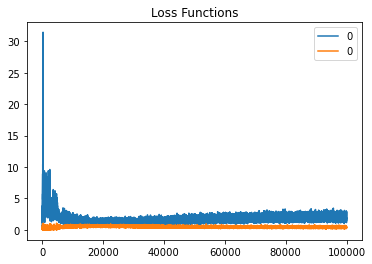

In [7]:
# Loss functions

fig, ax = plt.subplots()
pd.DataFrame(genlosses).plot(ax=ax, title='Loss Functions')
pd.DataFrame(disclosses).plot(ax=ax)

In [8]:
# Generator schema

model.generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 32)]                0         
                                                                 
 dense (Dense)               (32, 128)                 4224      
                                                                 
 re_lu (ReLU)                (32, 128)                 0         
                                                                 
 dense_1 (Dense)             (32, 256)                 33024     
                                                                 
 re_lu_1 (ReLU)              (32, 256)                 0         
                                                                 
 dense_2 (Dense)             (32, 512)                 131584    
                                                                 
 re_lu_2 (ReLU)              (32, 512)                 0     

In [9]:
# Discriminator schema

model.discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 11)]                0         
                                                                 
 dense_4 (Dense)             (32, 512)                 6144      
                                                                 
 leaky_re_lu (LeakyReLU)     (32, 512)                 0         
                                                                 
 dropout (Dropout)           (32, 512)                 0         
                                                                 
 dense_5 (Dense)             (32, 256)                 131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (32, 256)                 0         
                                                                 
 dropout_1 (Dropout)         (32, 256)                 0   

In [10]:
# GAN schema

model.gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (32, 11)                  174475    
                                                                 
 model_1 (Functional)        (32, 1)                   170497    
                                                                 
Total params: 344,972
Trainable params: 174,475
Non-trainable params: 170,497
_________________________________________________________________


## Tabular data generation

In [11]:
test_size = len(df) # number of generated cases
noise = np.random.normal(size=(test_size, noise_dim))
generator_model = model.generator
generator_model.load_weights(model_name+'/gen_weights_'+str(epochs-1)+'.h5')

g_z = generator_model.predict(noise)
dfgen = pd.DataFrame(g_z, columns=df.columns)
dfgen.to_csv(model_name+'/Generated_data.csv')

dfgen.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Outcome
0,-0.778330,-0.950386,0.790527,0.167490,0.196869,0.264924,-0.500631,0.293462,0.632338,-0.792526,0.741415
1,1.883511,1.035077,-0.050817,-0.644770,1.603223,1.928007,-0.623763,1.556010,0.652529,0.171668,-0.418823
2,0.851526,1.043756,-0.442898,0.732181,-0.309591,-0.160663,-0.327802,-0.499788,0.182876,-0.911266,-0.790650
3,-0.226875,-0.959080,-1.334101,-1.347947,0.141549,0.454347,-0.081843,-0.040739,-0.558650,-0.967868,-0.543671
4,1.760221,1.026847,0.128770,0.778427,2.670327,2.701495,-1.084770,2.322951,1.597446,0.322993,-0.166568


## Testing

In [12]:
# Wasserstein distance

wd = []
for c in df.columns:
    wdistance = wasserstein_distance(df[c], dfgen[c])
    wd.append(wdistance)

distances = pd.DataFrame(np.array(wd), np.array(df.columns), columns = ['Distance'])
distances = distances.reset_index()
distances.columns = ['Variable', 'Distance']

print(distances) 
print('\nMean Wasserstein Distance:', np.mean(wd))

   Variable  Distance
0       age  0.069254
1       sex  0.145971
2       bmi  0.146163
3        bp  0.203575
4        s1  0.121995
5        s2  0.077886
6        s3  0.076797
7        s4  0.166106
8        s5  0.152782
9        s6  0.132051
10  Outcome  0.198778

Mean Wasserstein Distance: 0.13557817011368634


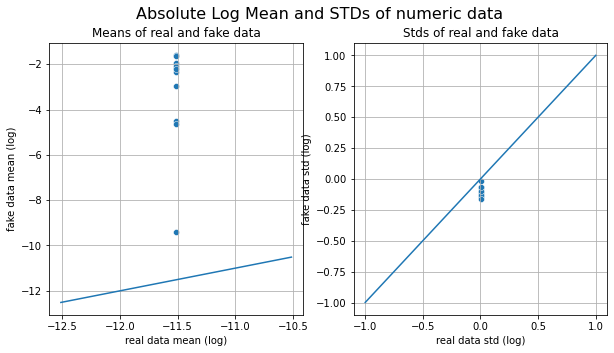

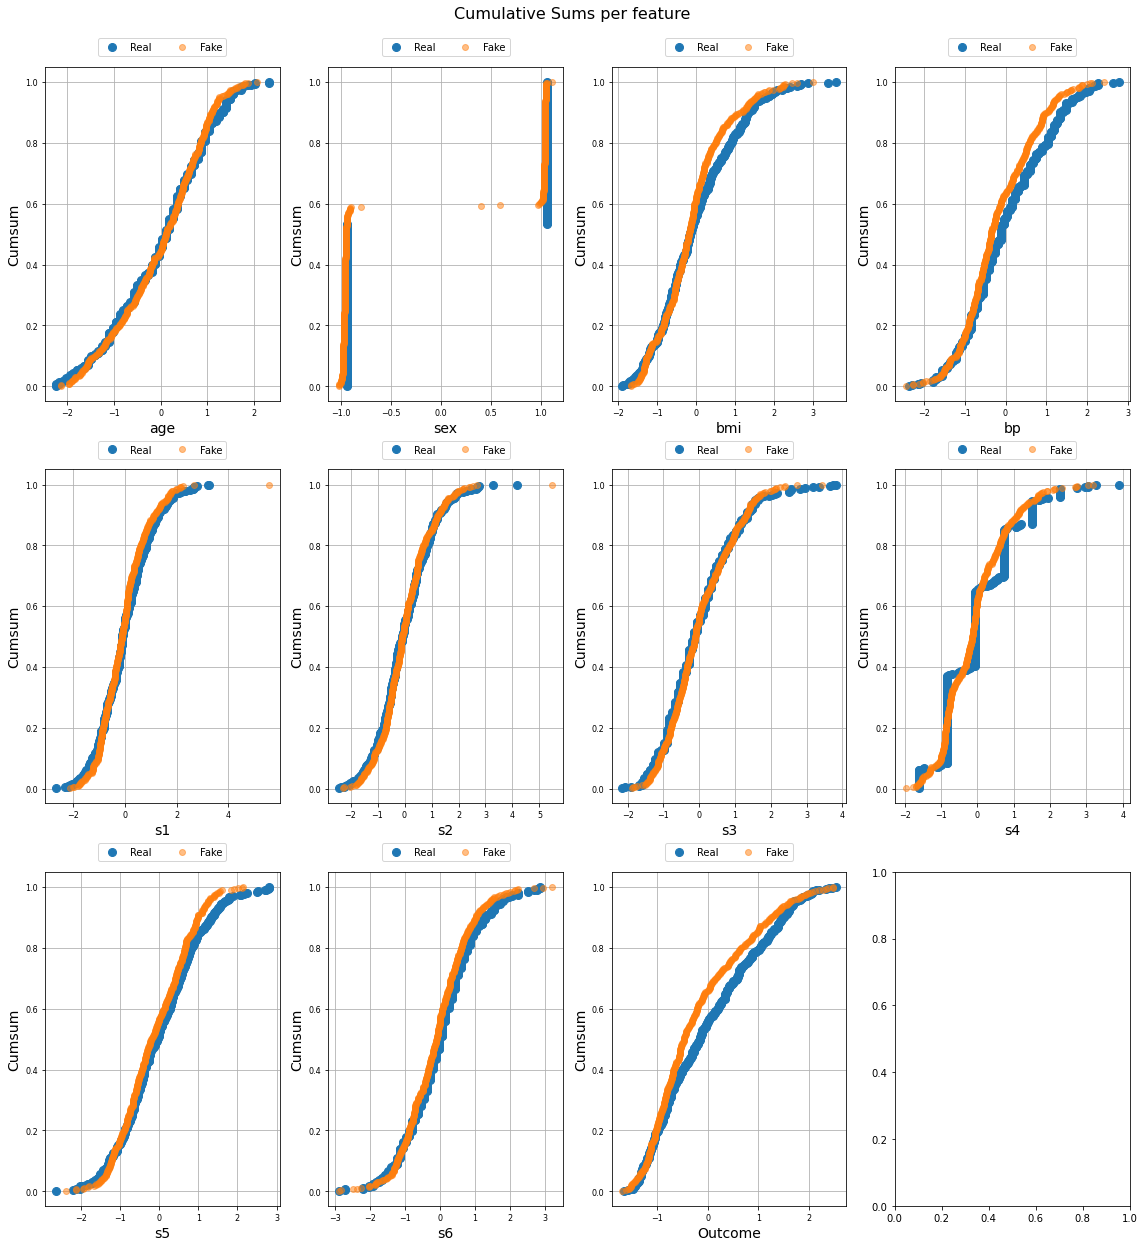

C:\Users\evaju\Downloads\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
C:\Users\evaju\Downloads\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
C:\Users\evaju\Downloads\table_evaluator\table_evaluator.py:156: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = pd.DataFrame({col: self.real[col].append(self.fake[col]), 'kind': ['real'] * self.n_samples + ['fake'] * self.n_samples})
C

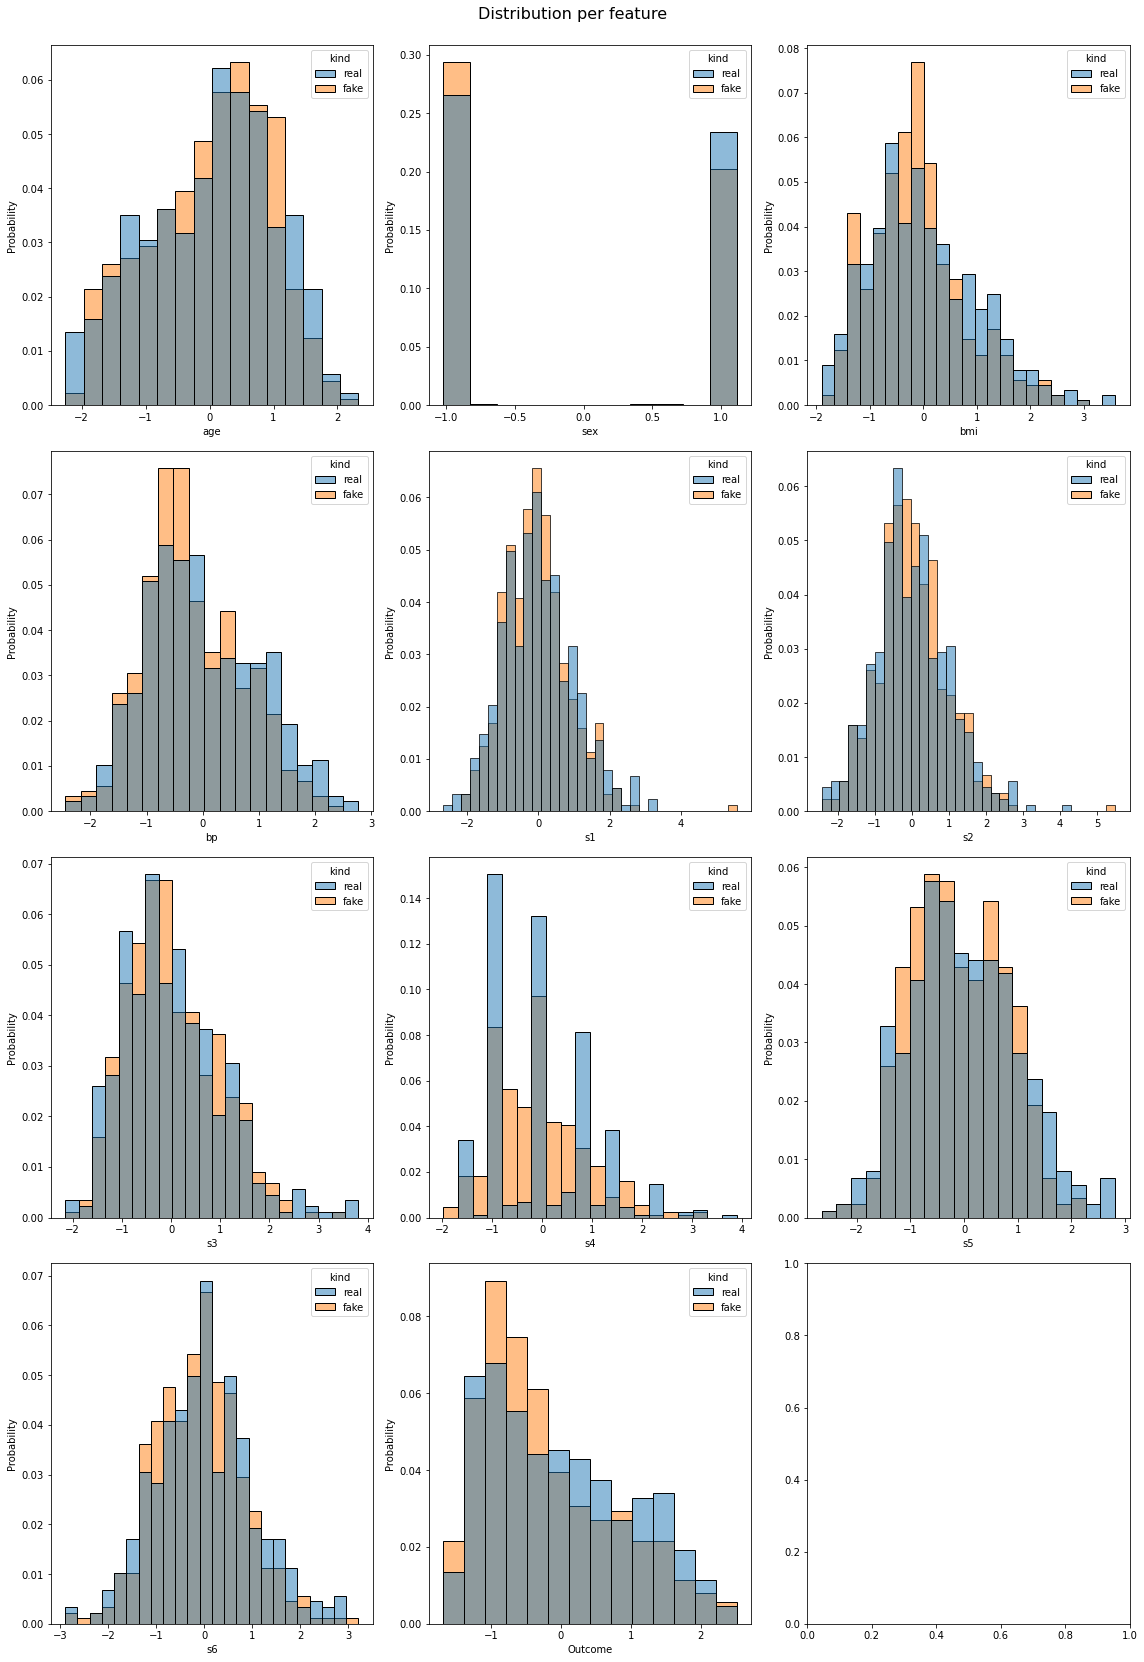

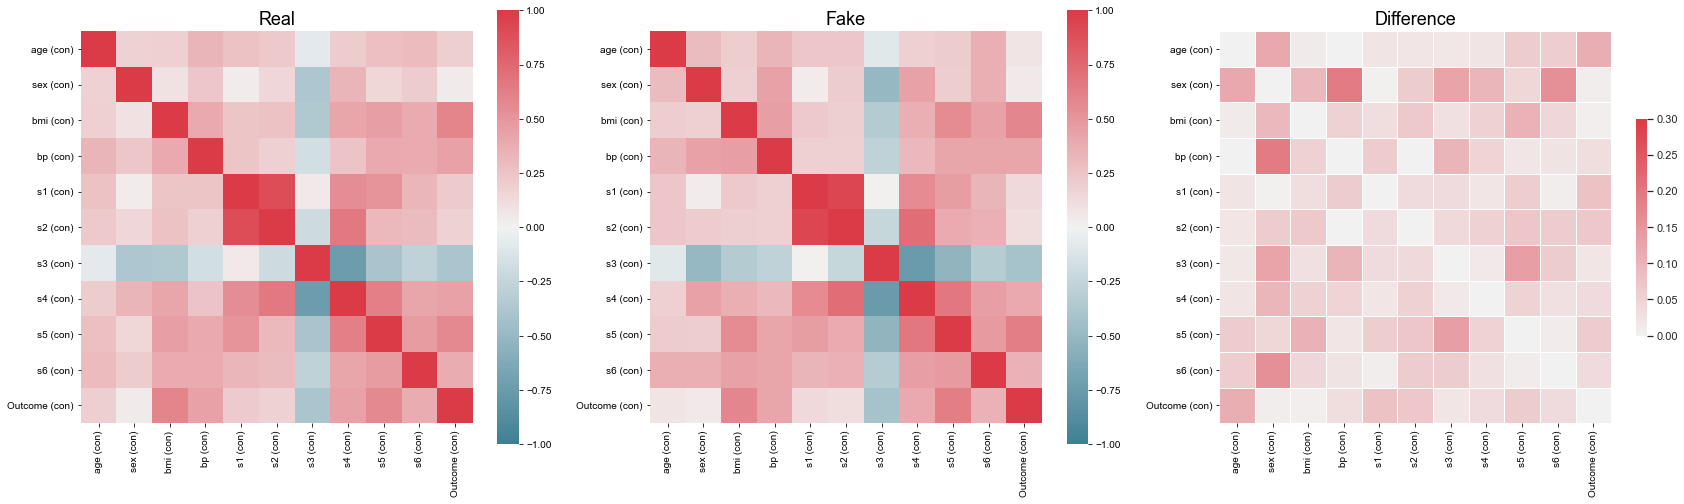

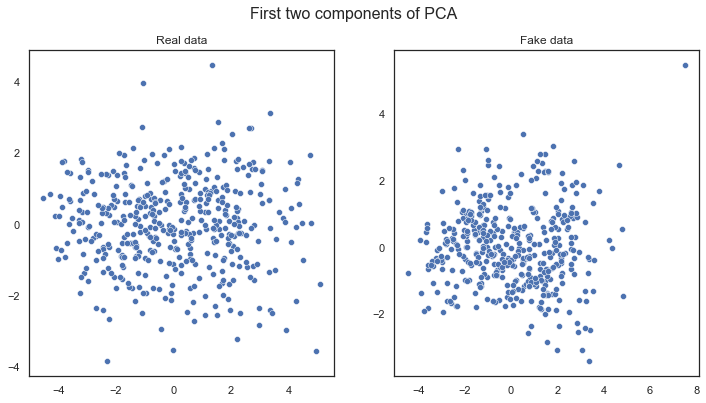

In [13]:
# Visual metrics

table_evaluator = TableEvaluator(df, dfgen)
table_evaluator.visual_evaluation()

## Save unstandarized generated dataset

In [14]:
dfgen_inv = pd.DataFrame(scaler.inverse_transform(dfgen), columns=dfgen.columns)
dfgen_inv.to_csv(model_name+'/Unstandarized_Generated_data.csv')

dfgen_inv.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Outcome
0,-0.037021,-0.045205,0.037602,0.007967,0.009364,0.012601,-0.023813,0.013959,0.030077,-0.037697,209.226715
1,0.089589,0.049234,-0.002417,-0.030669,0.076258,0.091706,-0.029669,0.074012,0.031038,0.008165,119.881721
2,0.040503,0.049646,-0.021067,0.034826,-0.014726,-0.007642,-0.015592,-0.023772,0.008699,-0.043344,91.248917
3,-0.010791,-0.045619,-0.063457,-0.064115,0.006733,0.021611,-0.003893,-0.001938,-0.026572,-0.046037,110.267670
4,0.083725,0.048842,0.006125,0.037026,0.127015,0.128497,-0.051597,0.110492,0.075983,0.015363,139.306824
